<a href="https://colab.research.google.com/github/jokefun022/Multi-Model-Cyberbullying-Detection-in-Roman-Urdu-using-Deep-Learning/blob/main/Yet_another_copy_of_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install numpy pandas scikit-learn matplotlib seaborn
# !pip install torch torchvision torchaudio
# !pip install tensorflow tensorflow-text tensorflow-decision-forests tf-keras
# !pip install gensim transformers huggingface_hub
# !pip install emoji joblib

In [ ]:
!pip install numpy pandas scikit-learn matplotlib seaborn

In [ ]:
!pip install torch torchvision torchaudio

In [ ]:
!pip install tensorflow tensorflow-text tensorflow-decision-forests tf-keras

In [ ]:
!pip install gensim transformers huggingface_hub

In [ ]:
!pip install emoji joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 9.8 MB/s eta 0:00:00


In [ ]:
# System & utilities
import os, gc, time, math, re, string, warnings
import pandas as pd
import numpy as np

# Sklearn - preprocessing, models, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB

# DL embeddings & NLP
from gensim.models import Word2Vec, FastText
from gensim.models import KeyedVectors  # for pre-trained embeddings
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import joblib
from tqdm import tqdm

# Transformers (Hugging Face)
import torch
from transformers import (AutoTokenizer, AutoModel, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments)

# Hugging Face Hub
from huggingface_hub import HfApi, HfFolder, Repository, login

# Keras / TensorFlow (DL models)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding, Dense, Dropout, Conv1D, MaxPooling1D, Flatten,
                                     LSTM, GRU, SimpleRNN, Bidirectional, GlobalAveragePooling1D)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print("✅ All libraries imported successfully")
print("Torch:", torch.__version__, " | TensorFlow:", tf.__version__)

✅ All libraries imported successfully
Torch: 2.8.0+cu126  | TensorFlow: 2.19.0


In [ ]:
DATA_PATH = "/content/Complete Data With Emoji.csv"  # path in Colab
df = pd.read_csv(DATA_PATH, encoding="utf-8")
# adjust column names here if necessary:
TEXT_COL = "Tweet_Text_With_Emoji"
LABEL_COL = "Label"

print("Rows:", len(df))
df.head()

Rows: 10672


,Tweet_Text_With_Emoji,Label,Sentiment Analysis
0,kah kay yih sach 😊 hai,0,Neutral
1,neither bhadwaa 😑 tantra rather madarjaat log ...,0,Neutral
2,kyoon okay yih kuchh logo ki 😃 fitrat hai,0,Neutral
3,lagta hsi man 🙌 chaaha job naey day rahay bhaa...,0,Neutral
4,achchha na bataao mujhay pata hai 😊,0,Neutral


In [ ]:
# Label encode
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df[LABEL_COL].astype(str))
num_classes = len(le.classes_)
print("Classes:", le.classes_, "Num:", num_classes)

Classes: ['0' '1' '2' '3' '4'] Num: 5


In [ ]:
# RND = 42
X = df[TEXT_COL].astype(str).tolist()
y = df['label_enc'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RND, stratify=y)
print("Train:", len(X_train), "Test:", len(X_test))


Train: 8537 Test: 2135


In [ ]:
# 3A: TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)

# 3B: Word2Vec (train on full texts tokenized)
sentences = [s.split() for s in X]  # simple whitespace tokenization; adapt if you have better tokenizer
w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4, epochs=10)
wv_dim = w2v.wv.vector_size

def avg_w2v_features(texts, model=w2v, dim=wv_dim):
    fv = []
    for t in texts:
        words = t.split()
        vecs = [model.wv[w] for w in words if w in model.wv]
        if vecs:
            fv.append(np.mean(vecs, axis=0))
        else:
            fv.append(np.zeros(dim))
    return np.vstack(fv)

X_train_w2v = avg_w2v_features(X_train)
X_test_w2v  = avg_w2v_features(X_test)
print("W2V shapes:", X_train_w2v.shape, X_test_w2v.shape)

# 3C: FastText
ft = FastText(sentences, vector_size=100, window=5, min_count=2, workers=4, epochs=10)
ft_dim = ft.wv.vector_size

def avg_ft_features(texts, model=ft, dim=ft_dim):
    fv = []
    for t in texts:
        words = t.split()
        vecs = [model.wv[w] for w in words if w in model.wv]
        if vecs:
            fv.append(np.mean(vecs, axis=0))
        else:
            fv.append(np.zeros(dim))
    return np.vstack(fv)

X_train_ft = avg_ft_features(X_train)
X_test_ft = avg_ft_features(X_test)
print("FastText shapes:", X_train_ft.shape, X_test_ft.shape)

# 3D: Emoji2Vec - simple approach: extract only emojis and run char ngram TF-IDF on emoji strings
import re
EMOJI_PATTERN = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
                           "]+", flags=re.UNICODE)

def extract_emojis(text):
    ems = EMOJI_PATTERN.findall(text)
    return " ".join(ems) if ems else ""

X_train_emoji = [extract_emojis(t) for t in X_train]
X_test_emoji  = [extract_emojis(t) for t in X_test]

# If no emojis in some rows, they will be empty strings; use char-level TF-IDF
emoji_vec = TfidfVectorizer(analyzer='char', ngram_range=(1,3), min_df=1)
X_train_emoji_tf = emoji_vec.fit_transform(X_train_emoji)
X_test_emoji_tf  = emoji_vec.transform(X_test_emoji)
print("Emoji TF shapes:", X_train_emoji_tf.shape, X_test_emoji_tf.shape)

# 3E: BERT (XLM-R) CLS embeddings (batched)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
bert = AutoModel.from_pretrained("xlm-roberta-base").to(device)
bert.eval()

def get_bert_cls(texts, batch_size=16):
    emb = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)
        with torch.no_grad():
            out = bert(**enc)
        cls = out.last_hidden_state[:,0,:].cpu().numpy()
        emb.append(cls)
    return np.vstack(emb)

# Be careful: this can take time and memory for large datasets. We'll compute full if feasible.
print("Computing BERT embeddings for train & test (this may take some time)...")
X_train_bert = get_bert_cls(X_train, batch_size=16)
X_test_bert  = get_bert_cls(X_test, batch_size=16)
print("BERT shapes:", X_train_bert.shape, X_test_bert.shape)


TF-IDF shapes: (8537, 5000) (2135, 5000)
W2V shapes: (8537, 100) (2135, 100)
FastText shapes: (8537, 100) (2135, 100)
Emoji TF shapes: (8537, 114) (2135, 114)
Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Computing BERT embeddings for train & test (this may take some time)...
BERT shapes: (8537, 768) (2135, 768)


In [ ]:
import itertools
def eval_and_report(name, y_true, y_pred, labels_list=None, output_prefix=None):
    acc = accuracy_score(y_true, y_pred)
    prec_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    print(f"\n{name} | Acc: {acc:.4f} | Prec(macro): {prec_macro:.4f} | Rec(macro): {rec_macro:.4f} | F1(macro): {f1_macro:.4f}")
    print(classification_report(y_true, y_pred, target_names=labels_list if labels_list is not None else le.classes_))
    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=(labels_list if labels_list else le.classes_), yticklabels=(labels_list if labels_list else le.classes_))
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"Confusion Matrix: {name}")
    if output_prefix:
        plt.savefig(f"{output_prefix}_confusion.png", bbox_inches='tight')
    plt.show()
    return {"accuracy": acc, "precision_macro": prec_macro, "recall_macro": rec_macro, "f1_macro": f1_macro}




==== FEATURE: TFIDF ====

>> Model: LogisticRegression

LogisticRegression + TFIDF | Acc: 0.9419 | Prec(macro): 0.9013 | Rec(macro): 0.9104 | F1(macro): 0.9050
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1211
           1       0.84      0.86      0.85       145
           2       0.97      0.89      0.92       628
           3       0.89      0.88      0.88        80
           4       0.86      0.94      0.90        71

    accuracy                           0.94      2135
   macro avg       0.90      0.91      0.91      2135
weighted avg       0.94      0.94      0.94      2135



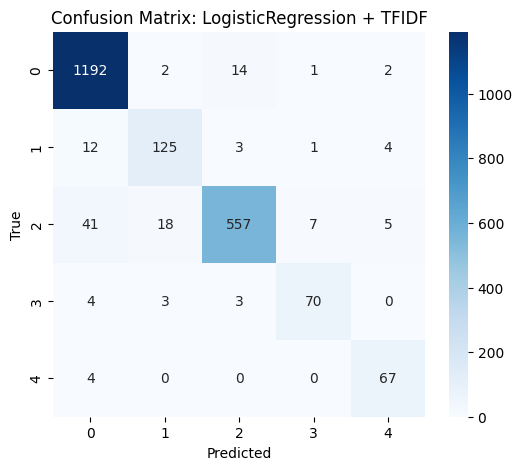


>> Model: SVM

SVM + TFIDF | Acc: 0.9630 | Prec(macro): 0.9551 | Rec(macro): 0.9218 | F1(macro): 0.9373
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1211
           1       0.93      0.83      0.88       145
           2       0.98      0.94      0.96       628
           3       0.99      0.90      0.94        80
           4       0.92      0.94      0.93        71

    accuracy                           0.96      2135
   macro avg       0.96      0.92      0.94      2135
weighted avg       0.96      0.96      0.96      2135



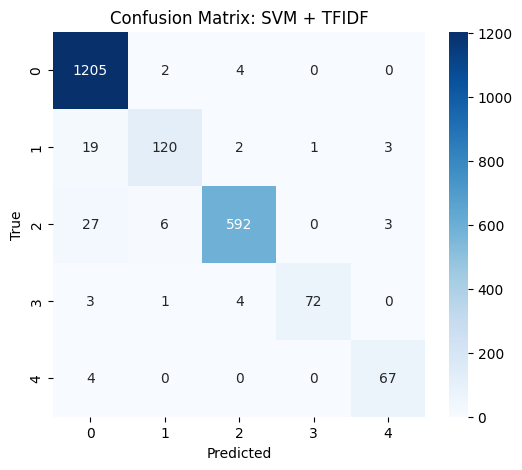


>> Model: RandomForest

RandomForest + TFIDF | Acc: 0.9607 | Prec(macro): 0.9379 | Rec(macro): 0.9105 | F1(macro): 0.9233
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1211
           1       0.89      0.90      0.89       145
           2       0.99      0.92      0.95       628
           3       0.93      0.82      0.87        80
           4       0.93      0.90      0.91        71

    accuracy                           0.96      2135
   macro avg       0.94      0.91      0.92      2135
weighted avg       0.96      0.96      0.96      2135



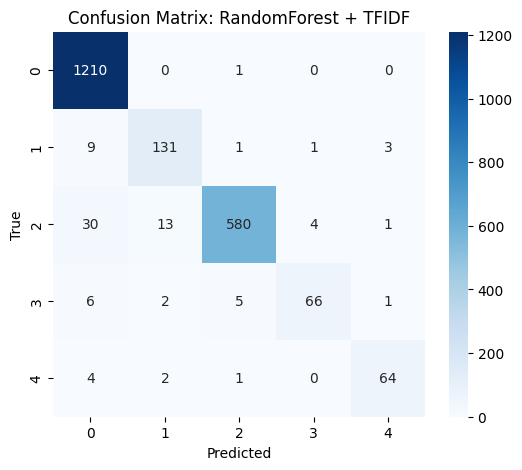


>> Model: DecisionTree

DecisionTree + TFIDF | Acc: 0.9607 | Prec(macro): 0.8809 | Rec(macro): 0.9240 | F1(macro): 0.9006
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1211
           1       0.83      0.85      0.84       145
           2       0.98      0.93      0.95       628
           3       0.81      0.89      0.85        80
           4       0.80      0.96      0.87        71

    accuracy                           0.96      2135
   macro avg       0.88      0.92      0.90      2135
weighted avg       0.96      0.96      0.96      2135



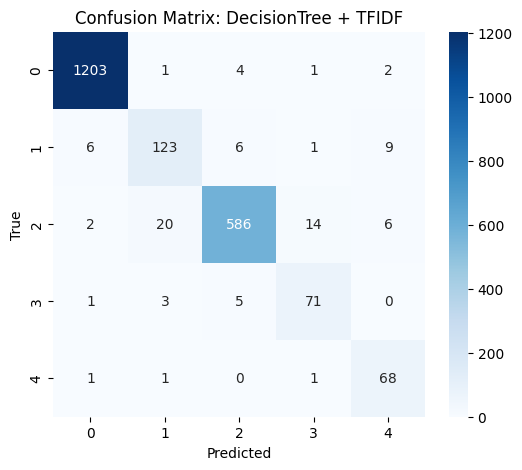


>> Model: GradientBoosting

GradientBoosting + TFIDF | Acc: 0.9480 | Prec(macro): 0.9050 | Rec(macro): 0.9209 | F1(macro): 0.9113
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1211
           1       0.86      0.85      0.85       145
           2       0.99      0.87      0.93       628
           3       0.86      0.93      0.89        80
           4       0.86      0.96      0.91        71

    accuracy                           0.95      2135
   macro avg       0.90      0.92      0.91      2135
weighted avg       0.95      0.95      0.95      2135



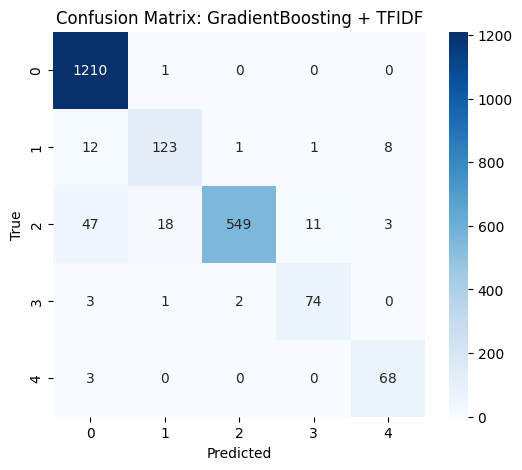


>> Model: NaiveBayes

NaiveBayes + TFIDF | Acc: 0.8197 | Prec(macro): 0.8674 | Rec(macro): 0.4921 | F1(macro): 0.5533
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1211
           1       0.81      0.26      0.40       145
           2       0.83      0.78      0.80       628
           3       1.00      0.11      0.20        80
           4       0.88      0.32      0.47        71

    accuracy                           0.82      2135
   macro avg       0.87      0.49      0.55      2135
weighted avg       0.83      0.82      0.79      2135



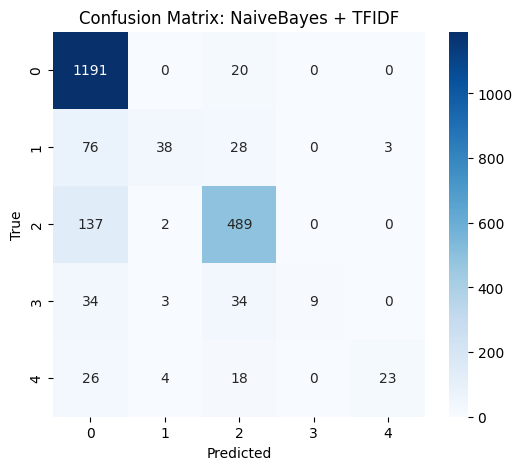



==== FEATURE: Word2Vec ====

>> Model: LogisticRegression

LogisticRegression + Word2Vec | Acc: 0.8070 | Prec(macro): 0.6139 | Rec(macro): 0.7180 | F1(macro): 0.6464
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      1211
           1       0.55      0.72      0.62       145
           2       0.81      0.69      0.74       628
           3       0.47      0.64      0.54        80
           4       0.29      0.65      0.40        71

    accuracy                           0.81      2135
   macro avg       0.61      0.72      0.65      2135
weighted avg       0.84      0.81      0.82      2135



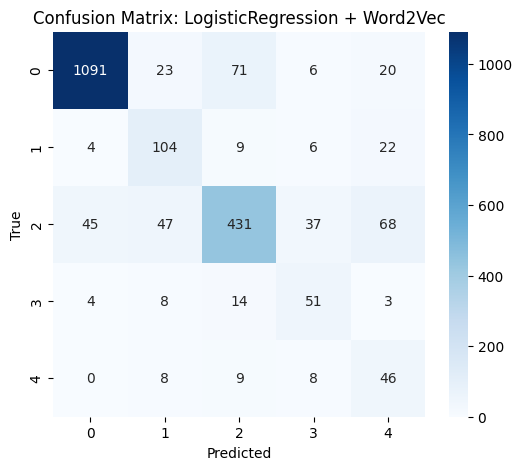


>> Model: SVM

SVM + Word2Vec | Acc: 0.8773 | Prec(macro): 0.7313 | Rec(macro): 0.7615 | F1(macro): 0.7418
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1211
           1       0.64      0.70      0.67       145
           2       0.88      0.81      0.84       628
           3       0.68      0.62      0.65        80
           4       0.50      0.72      0.59        71

    accuracy                           0.88      2135
   macro avg       0.73      0.76      0.74      2135
weighted avg       0.88      0.88      0.88      2135



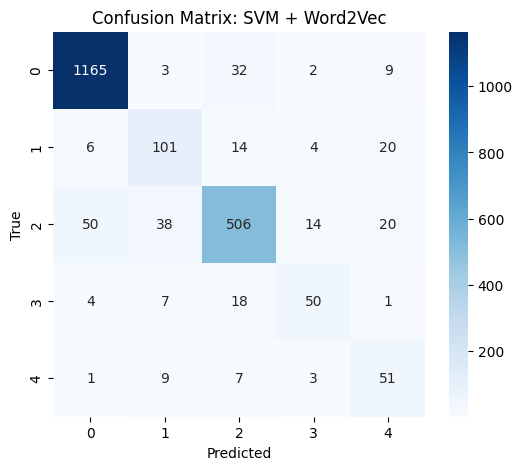


>> Model: RandomForest

RandomForest + Word2Vec | Acc: 0.8496 | Prec(macro): 0.8561 | Rec(macro): 0.6672 | F1(macro): 0.7348
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1211
           1       0.82      0.57      0.67       145
           2       0.81      0.78      0.79       628
           3       0.97      0.49      0.65        80
           4       0.81      0.54      0.64        71

    accuracy                           0.85      2135
   macro avg       0.86      0.67      0.73      2135
weighted avg       0.85      0.85      0.84      2135



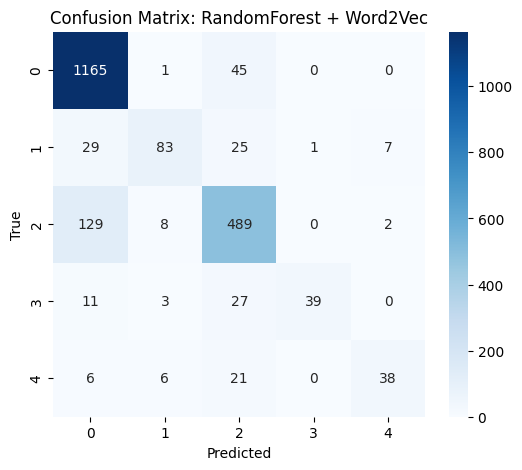


>> Model: DecisionTree

DecisionTree + Word2Vec | Acc: 0.7363 | Prec(macro): 0.5938 | Rec(macro): 0.5905 | F1(macro): 0.5904
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1211
           1       0.46      0.52      0.49       145
           2       0.65      0.64      0.64       628
           3       0.52      0.55      0.53        80
           4       0.50      0.39      0.44        71

    accuracy                           0.74      2135
   macro avg       0.59      0.59      0.59      2135
weighted avg       0.74      0.74      0.74      2135



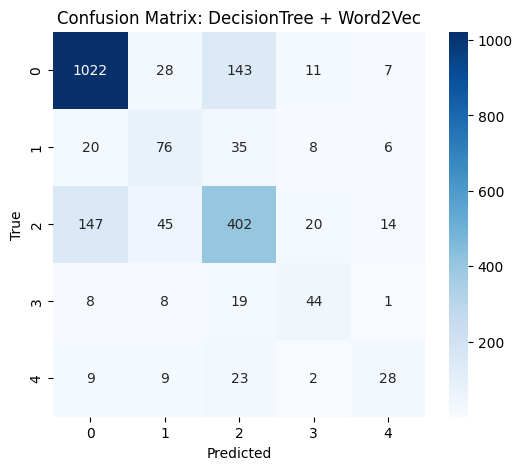


>> Model: GradientBoosting


KeyboardInterrupt: 

In [ ]:
# Prepare feature matrix dictionary for convenience
features = {
    "TFIDF": (X_train_tfidf, X_test_tfidf),
    "Word2Vec": (X_train_w2v, X_test_w2v),
    "FastText": (X_train_ft, X_test_ft),
    "Emoji2Vec": (X_train_emoji_tf, X_test_emoji_tf),
    "BERT": (X_train_bert, X_test_bert)
}

ml_models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "SVM": LinearSVC(class_weight='balanced', max_iter=2000),
    "RandomForest": RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight='balanced'),
    "DecisionTree": DecisionTreeClassifier(class_weight='balanced'),
    "GradientBoosting": GradientBoostingClassifier(),
    "NaiveBayes": MultinomialNB()
}

results = []
os.makedirs("conf_matrices", exist_ok=True) # Use conf_matrices consistently

for feat_name, (Xtr, Xte) in features.items():
    print("\n\n==== FEATURE:", feat_name, "====")
    # If sparse (TF-IDF, emoji TF), OK; if dense numpy, it's fine too.
    for model_name, model in ml_models.items():
        # Skip Naive Bayes for Word2Vec and BERT
        if model_name == "NaiveBayes" and (feat_name == "Word2Vec" or feat_name == "BERT"):
             print(f"\n>> Skipping NaiveBayes with {feat_name} (requires non-negative input)")
             continue

        print("\n>> Model:", model_name)
        # Some models (MultinomialNB) need non-negative inputs; ensure TFIDF or emoji features used for NB
        try:
            model_instance = model
            model_instance.fit(Xtr, y_train)
            y_pred = model_instance.predict(Xte)
            r = eval_and_report(f"{model_name} + {feat_name}", y_test, y_pred, output_prefix=f"conf_matrices/{model_name}_{feat_name}")
            r.update({"model": model_name, "feature": feat_name})
            results.append(r)
            # Save model file
            os.makedirs("models", exist_ok=True) # Ensure models directory exists
            joblib.dump(model_instance, f"models/{model_name}_{feat_name}.joblib")
        except Exception as e:
            print("Error training", model_name, feat_name, "->", e)
        gc.collect()

# Save results DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv("ml_results_summary.csv", index=False)
# Removed sort_values and head(20) as the DataFrame might be empty initially and this was causing a KeyError

In [ ]:

# Tokenize everything
MAX_WORDS = 20000
MAX_LEN = 80
tk = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tk.fit_on_texts(X)  # fit on whole corpus
vocab_size = min(MAX_WORDS, len(tk.word_index)+1)
print("Vocab size:", vocab_size)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Prepare embedding matrices for different models
def build_embedding_matrix(model_name, model, token_index, dim):
    emb_matrix = np.zeros((vocab_size, dim))
    for word, i in token_index.items():
        if i>=vocab_size: continue
        if model_name == "TFIDF" or model_name == "Emoji2Vec":
            if word in model.vocabulary_:
                vocab_index = model.vocabulary_[word]
                emb_matrix[i][0] = model.idf_[vocab_index] # Assuming dim is 1
            else:
                 emb_matrix[i][0] = np.random.normal(scale=0.1, size=(1,))[0]
        elif model_name == "Word2Vec" or model_name == "FastText":
            if hasattr(model, 'wv') and word in model.wv:
                emb_matrix[i] = model.wv[word]
            else:
                emb_matrix[i] = np.random.normal(scale=0.6, size=(dim,))
        elif model_name == "BERT":
             # As noted before, this is not standard. Assign random for now.
             emb_matrix[i] = np.random.normal(scale=0.6, size=(dim,))
        else: # For RAND
            emb_matrix[i] = np.random.normal(scale=0.6, size=(dim,))
    return emb_matrix


# Build embedding matrices
tfidf_emb_matrix = build_embedding_matrix("TFIDF", tfidf, tk.word_index, 1) # Use dim 1 for simple IDF embedding
emoji_vec_emb_matrix = build_embedding_matrix("Emoji2Vec", emoji_vec, tk.word_index, 1) # Use dim 1 for simple IDF embedding
w2v_emb_matrix = build_embedding_matrix("Word2Vec", w2v, tk.word_index, wv_dim)
ft_emb_matrix  = build_embedding_matrix("FastText", ft, tk.word_index, ft_dim)
bert_emb_matrix = build_embedding_matrix("BERT", None, tk.word_index, X_train_bert.shape[1]) # Pass None for model as BERT embeddings are precomputed

y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat  = to_categorical(y_test, num_classes=num_classes)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat  = to_categorical(y_test, num_classes=num_classes)

Vocab size: 16539



=== DL: CNN with TFIDF embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 6s - 47ms/step - accuracy: 0.5606 - loss: 1.1189 - val_accuracy: 0.5621 - val_loss: 1.0963
Epoch 2/8


121/121 - 1s - 8ms/step - accuracy: 0.5767 - loss: 1.0542 - val_accuracy: 0.5855 - val_loss: 1.0727
Epoch 3/8


121/121 - 1s - 5ms/step - accuracy: 0.5992 - loss: 1.0289 - val_accuracy: 0.5749 - val_loss: 1.0704
Epoch 4/8


121/121 - 0s - 4ms/step - accuracy: 0.6039 - loss: 1.0148 - val_accuracy: 0.5656 - val_loss: 1.0700
Epoch 5/8


121/121 - 0s - 4ms/step - accuracy: 0.6098 - loss: 1.0001 - val_accuracy: 0.5913 - val_loss: 1.0639
Epoch 6/8
121/121 - 0s - 3ms/step - accuracy: 0.6127 - loss: 0.9854 - val_accuracy: 0.5808 - val_loss: 1.0673
Epoch 7/8


121/121 - 0s - 4ms/step - accuracy: 0.6206 - loss: 0.9707 - val_accuracy: 0.5831 - val_loss: 1.0636
Epoch 8/8


121/121 - 1s - 5ms/step - accuracy: 0.6214 - loss: 0.9695 - val_accuracy: 0.5902 - val_loss: 1.0550
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

CNN + TFIDF | Acc: 0.6075 | Prec(macro): 0.3800 | Rec(macro): 0.2770 | F1(macro): 0.2827
              precision    recall  f1-score   support

           0       0.63      0.88      0.73      1211
           1       0.33      0.13      0.19       145
           2       0.57      0.33      0.42       628
           3       0.00      0.00      0.00        80
           4       0.38      0.04      0.08        71

    accuracy                           0.61      2135
   macro avg       0.38      0.28      0.28      2135
weighted avg       0.56      0.61      0.55      2135



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


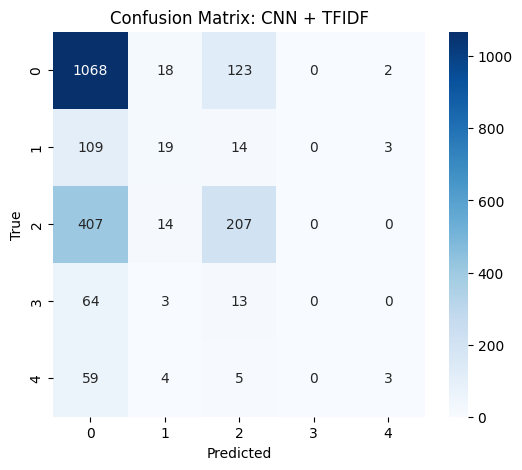


=== DL: RNN with TFIDF embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 8s - 63ms/step - accuracy: 0.5430 - loss: 1.1510 - val_accuracy: 0.5691 - val_loss: 1.1396
Epoch 2/8


121/121 - 5s - 44ms/step - accuracy: 0.5637 - loss: 1.1162 - val_accuracy: 0.5691 - val_loss: 1.1270
Epoch 3/8
121/121 - 1s - 9ms/step - accuracy: 0.5671 - loss: 1.1113 - val_accuracy: 0.5691 - val_loss: 1.1370
Epoch 4/8
121/121 - 1s - 7ms/step - accuracy: 0.5674 - loss: 1.1112 - val_accuracy: 0.5691 - val_loss: 1.1297
Epoch 5/8
121/121 - 1s - 12ms/step - accuracy: 0.5671 - loss: 1.1058 - val_accuracy: 0.5691 - val_loss: 1.1304
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

RNN + TFIDF | Acc: 0.5672 | Prec(macro): 0.1134 | Rec(macro): 0.2000 | F1(macro): 0.1448
              precision    recall  f1-score   support

           0       0.57      1.00      0.72      1211
           1       0.00      0.00      0.00       145
           2       0.00      0.00      0.00       628
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        71

    accuracy                           0.57      2135
   macro avg       0.11      0.20      0.14      2135
weig

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


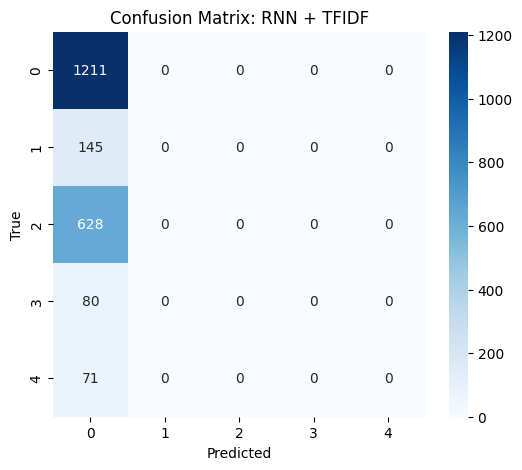


=== DL: LSTM with TFIDF embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 7s - 55ms/step - accuracy: 0.5608 - loss: 1.1567 - val_accuracy: 0.5691 - val_loss: 1.1301
Epoch 2/8


121/121 - 1s - 9ms/step - accuracy: 0.5666 - loss: 1.1057 - val_accuracy: 0.5691 - val_loss: 1.1241
Epoch 3/8
121/121 - 1s - 11ms/step - accuracy: 0.5671 - loss: 1.1025 - val_accuracy: 0.5691 - val_loss: 1.1389
Epoch 4/8


121/121 - 2s - 18ms/step - accuracy: 0.5674 - loss: 1.0940 - val_accuracy: 0.5691 - val_loss: 1.1133
Epoch 5/8


121/121 - 1s - 9ms/step - accuracy: 0.5661 - loss: 1.0913 - val_accuracy: 0.5679 - val_loss: 1.0980
Epoch 6/8
121/121 - 1s - 10ms/step - accuracy: 0.5658 - loss: 1.0860 - val_accuracy: 0.5667 - val_loss: 1.1066
Epoch 7/8


121/121 - 1s - 8ms/step - accuracy: 0.5657 - loss: 1.0872 - val_accuracy: 0.5691 - val_loss: 1.0956
Epoch 8/8


121/121 - 1s - 11ms/step - accuracy: 0.5654 - loss: 1.0900 - val_accuracy: 0.5574 - val_loss: 1.0945
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

LSTM + TFIDF | Acc: 0.5625 | Prec(macro): 0.1775 | Rec(macro): 0.2049 | F1(macro): 0.1669
              precision    recall  f1-score   support

           0       0.58      0.96      0.72      1211
           1       0.00      0.00      0.00       145
           2       0.31      0.07      0.11       628
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        71

    accuracy                           0.56      2135
   macro avg       0.18      0.20      0.17      2135
weighted avg       0.42      0.56      0.44      2135



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


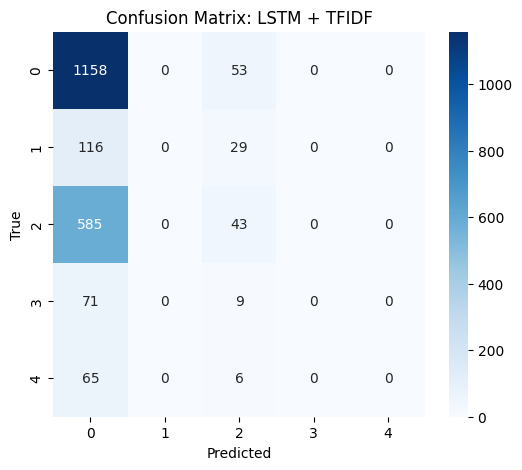


=== DL: BiLSTM with TFIDF embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 5s - 41ms/step - accuracy: 0.5555 - loss: 1.1287 - val_accuracy: 0.5667 - val_loss: 1.1227
Epoch 2/8


121/121 - 1s - 12ms/step - accuracy: 0.5680 - loss: 1.0855 - val_accuracy: 0.5632 - val_loss: 1.0986
Epoch 3/8


121/121 - 1s - 12ms/step - accuracy: 0.5679 - loss: 1.0829 - val_accuracy: 0.5562 - val_loss: 1.0886
Epoch 4/8


121/121 - 2s - 21ms/step - accuracy: 0.5722 - loss: 1.0682 - val_accuracy: 0.5749 - val_loss: 1.0756
Epoch 5/8
121/121 - 3s - 21ms/step - accuracy: 0.5722 - loss: 1.0705 - val_accuracy: 0.5749 - val_loss: 1.0758
Epoch 6/8
121/121 - 3s - 24ms/step - accuracy: 0.5800 - loss: 1.0599 - val_accuracy: 0.5656 - val_loss: 1.0784
Epoch 7/8


121/121 - 2s - 18ms/step - accuracy: 0.5904 - loss: 1.0473 - val_accuracy: 0.5948 - val_loss: 1.0505
Epoch 8/8
121/121 - 1s - 12ms/step - accuracy: 0.5934 - loss: 1.0401 - val_accuracy: 0.5667 - val_loss: 1.0625
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

BiLSTM + TFIDF | Acc: 0.5925 | Prec(macro): 0.2380 | Rec(macro): 0.2267 | F1(macro): 0.2023
              precision    recall  f1-score   support

           0       0.59      0.95      0.73      1211
           1       0.00      0.00      0.00       145
           2       0.60      0.18      0.28       628
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        71

    accuracy                           0.59      2135
   macro avg       0.24      0.23      0.20      2135
weighted avg       0.51      0.59      0.50      2135



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


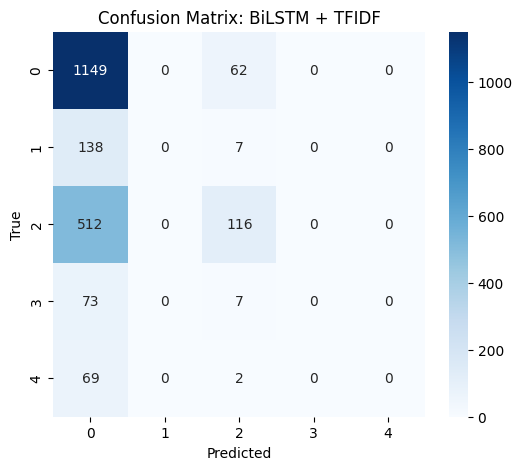


=== DL: GRU with TFIDF embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 3s - 24ms/step - accuracy: 0.5573 - loss: 1.1694 - val_accuracy: 0.5691 - val_loss: 1.1240
Epoch 2/8
121/121 - 3s - 21ms/step - accuracy: 0.5668 - loss: 1.1061 - val_accuracy: 0.5691 - val_loss: 1.1434
Epoch 3/8


121/121 - 1s - 8ms/step - accuracy: 0.5672 - loss: 1.1036 - val_accuracy: 0.5691 - val_loss: 1.1178
Epoch 4/8


121/121 - 1s - 8ms/step - accuracy: 0.5670 - loss: 1.0956 - val_accuracy: 0.5667 - val_loss: 1.1096
Epoch 5/8


121/121 - 1s - 9ms/step - accuracy: 0.5664 - loss: 1.0924 - val_accuracy: 0.5667 - val_loss: 1.1054
Epoch 6/8


121/121 - 1s - 9ms/step - accuracy: 0.5666 - loss: 1.0861 - val_accuracy: 0.5691 - val_loss: 1.1001
Epoch 7/8


121/121 - 1s - 10ms/step - accuracy: 0.5666 - loss: 1.0865 - val_accuracy: 0.5585 - val_loss: 1.0991
Epoch 8/8
121/121 - 1s - 8ms/step - accuracy: 0.5654 - loss: 1.0811 - val_accuracy: 0.5679 - val_loss: 1.1079
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

GRU + TFIDF | Acc: 0.5649 | Prec(macro): 0.1775 | Rec(macro): 0.2039 | F1(macro): 0.1618
              precision    recall  f1-score   support

           0       0.58      0.97      0.72      1211
           1       0.00      0.00      0.00       145
           2       0.31      0.05      0.09       628
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        71

    accuracy                           0.56      2135
   macro avg       0.18      0.20      0.16      2135
weighted avg       0.42      0.56      0.44      2135



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


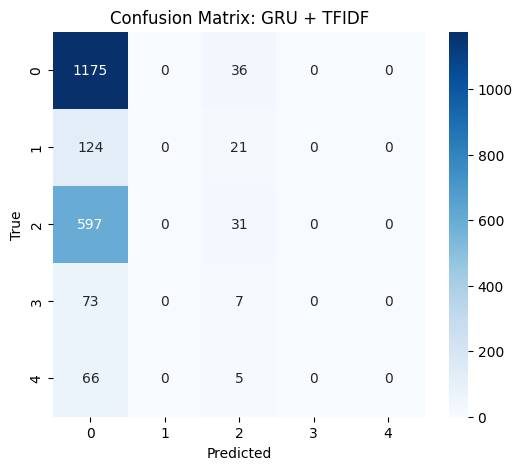


=== DL: CNN with Word2Vec embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 7s - 59ms/step - accuracy: 0.6915 - loss: 0.8236 - val_accuracy: 0.8009 - val_loss: 0.6325
Epoch 2/8


121/121 - 5s - 39ms/step - accuracy: 0.8230 - loss: 0.5447 - val_accuracy: 0.8302 - val_loss: 0.5316
Epoch 3/8


121/121 - 1s - 5ms/step - accuracy: 0.8533 - loss: 0.4521 - val_accuracy: 0.8407 - val_loss: 0.4999
Epoch 4/8


121/121 - 1s - 4ms/step - accuracy: 0.8731 - loss: 0.3768 - val_accuracy: 0.8642 - val_loss: 0.4330
Epoch 5/8


121/121 - 1s - 4ms/step - accuracy: 0.8941 - loss: 0.3197 - val_accuracy: 0.8630 - val_loss: 0.4141
Epoch 6/8


121/121 - 1s - 5ms/step - accuracy: 0.9059 - loss: 0.2854 - val_accuracy: 0.8712 - val_loss: 0.3936
Epoch 7/8


121/121 - 1s - 6ms/step - accuracy: 0.9197 - loss: 0.2392 - val_accuracy: 0.8829 - val_loss: 0.3889
Epoch 8/8
121/121 - 1s - 6ms/step - accuracy: 0.9262 - loss: 0.2194 - val_accuracy: 0.8794 - val_loss: 0.4046
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

CNN + Word2Vec | Acc: 0.8778 | Prec(macro): 0.7782 | Rec(macro): 0.7133 | F1(macro): 0.7356
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1211
           1       0.61      0.74      0.67       145
           2       0.86      0.81      0.84       628
           3       0.88      0.55      0.68        80
           4       0.60      0.49      0.54        71

    accuracy                           0.88      2135
   macro avg       0.78      0.71      0.74      2135
weighted avg       0.88      0.88      0.88      2135



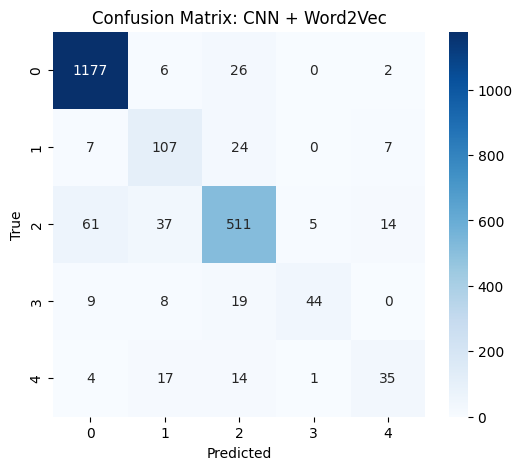


=== DL: RNN with Word2Vec embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 7s - 58ms/step - accuracy: 0.5476 - loss: 1.1235 - val_accuracy: 0.6218 - val_loss: 1.0382
Epoch 2/8


121/121 - 6s - 50ms/step - accuracy: 0.6128 - loss: 0.9862 - val_accuracy: 0.6698 - val_loss: 0.9009
Epoch 3/8


121/121 - 1s - 9ms/step - accuracy: 0.6583 - loss: 0.9271 - val_accuracy: 0.6944 - val_loss: 0.8692
Epoch 4/8
121/121 - 1s - 8ms/step - accuracy: 0.6870 - loss: 0.8679 - val_accuracy: 0.6909 - val_loss: 0.9302
Epoch 5/8
121/121 - 1s - 8ms/step - accuracy: 0.5786 - loss: 1.0880 - val_accuracy: 0.5691 - val_loss: 1.1285
Epoch 6/8
121/121 - 1s - 8ms/step - accuracy: 0.5610 - loss: 1.1259 - val_accuracy: 0.5691 - val_loss: 1.1402
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

RNN + Word2Vec | Acc: 0.7129 | Prec(macro): 0.2739 | Rec(macro): 0.3225 | F1(macro): 0.2948
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1211
           1       0.00      0.00      0.00       145
           2       0.53      0.74      0.62       628
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        71

    accuracy                           0.71      2135
   macro avg       0.27      0.32      0.29      2135
weig

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


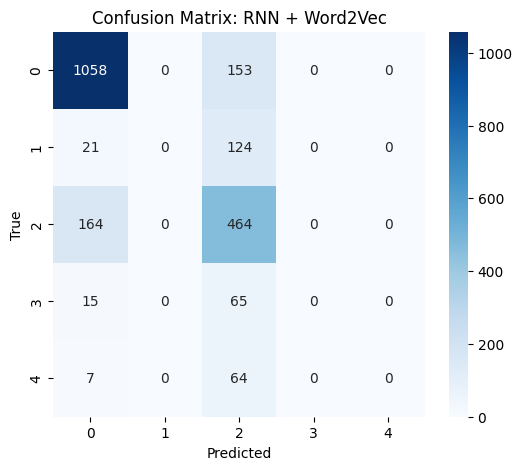


=== DL: LSTM with Word2Vec embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 4s - 30ms/step - accuracy: 0.5619 - loss: 1.0891 - val_accuracy: 0.6077 - val_loss: 1.0212
Epoch 2/8


121/121 - 1s - 9ms/step - accuracy: 0.6637 - loss: 0.8374 - val_accuracy: 0.7646 - val_loss: 0.7221
Epoch 3/8


121/121 - 1s - 10ms/step - accuracy: 0.7708 - loss: 0.7101 - val_accuracy: 0.7553 - val_loss: 0.7055
Epoch 4/8


121/121 - 1s - 8ms/step - accuracy: 0.8126 - loss: 0.6088 - val_accuracy: 0.8326 - val_loss: 0.5720
Epoch 5/8
121/121 - 1s - 11ms/step - accuracy: 0.8001 - loss: 0.6608 - val_accuracy: 0.8126 - val_loss: 0.6072
Epoch 6/8


121/121 - 1s - 8ms/step - accuracy: 0.8199 - loss: 0.6020 - val_accuracy: 0.8244 - val_loss: 0.5716
Epoch 7/8
121/121 - 1s - 8ms/step - accuracy: 0.8124 - loss: 0.6290 - val_accuracy: 0.5925 - val_loss: 1.0617
Epoch 8/8
121/121 - 1s - 11ms/step - accuracy: 0.8184 - loss: 0.6106 - val_accuracy: 0.8126 - val_loss: 0.5931
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

LSTM + Word2Vec | Acc: 0.8393 | Prec(macro): 0.4887 | Rec(macro): 0.4324 | F1(macro): 0.4290
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1211
           1       0.81      0.27      0.40       145
           2       0.67      0.93      0.78       628
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        71

    accuracy                           0.84      2135
   macro avg       0.49      0.43      0.43      2135
weighted avg       0.80      0.84      0.80      2135



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


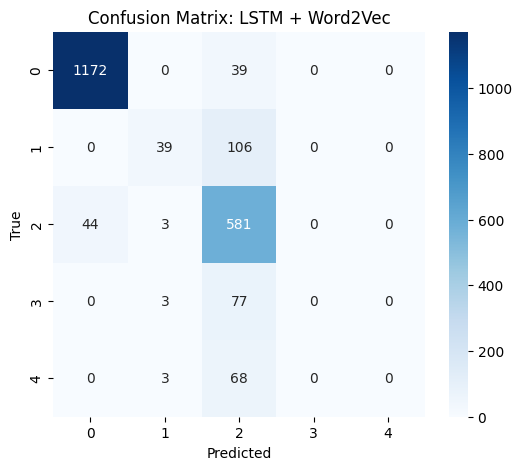


=== DL: BiLSTM with Word2Vec embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 4s - 37ms/step - accuracy: 0.6747 - loss: 0.8774 - val_accuracy: 0.7588 - val_loss: 0.6999
Epoch 2/8


121/121 - 1s - 12ms/step - accuracy: 0.8196 - loss: 0.5752 - val_accuracy: 0.8513 - val_loss: 0.4632
Epoch 3/8


121/121 - 3s - 21ms/step - accuracy: 0.8519 - loss: 0.4760 - val_accuracy: 0.8595 - val_loss: 0.4431
Epoch 4/8


121/121 - 3s - 22ms/step - accuracy: 0.8646 - loss: 0.4305 - val_accuracy: 0.8759 - val_loss: 0.3901
Epoch 5/8
121/121 - 2s - 20ms/step - accuracy: 0.8672 - loss: 0.4252 - val_accuracy: 0.8689 - val_loss: 0.4155
Epoch 6/8


121/121 - 3s - 21ms/step - accuracy: 0.8737 - loss: 0.4022 - val_accuracy: 0.8841 - val_loss: 0.3713
Epoch 7/8


121/121 - 3s - 21ms/step - accuracy: 0.8771 - loss: 0.3789 - val_accuracy: 0.8852 - val_loss: 0.3659
Epoch 8/8
121/121 - 1s - 11ms/step - accuracy: 0.8808 - loss: 0.3605 - val_accuracy: 0.8817 - val_loss: 0.3731
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

BiLSTM + Word2Vec | Acc: 0.8707 | Prec(macro): 0.7241 | Rec(macro): 0.6429 | F1(macro): 0.6673
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1211
           1       0.72      0.61      0.66       145
           2       0.79      0.86      0.82       628
           3       0.47      0.49      0.48        80
           4       0.68      0.30      0.41        71

    accuracy                           0.87      2135
   macro avg       0.72      0.64      0.67      2135
weighted avg       0.87      0.87      0.87      2135



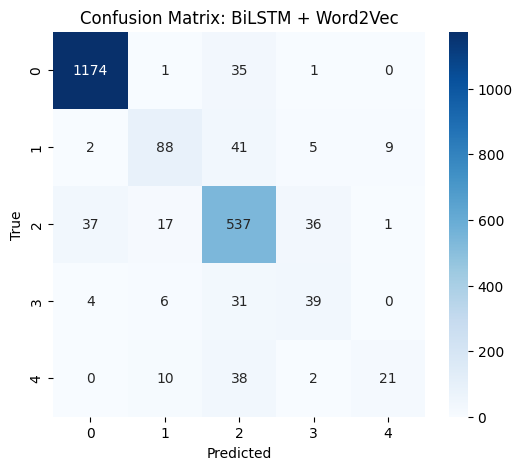


=== DL: GRU with Word2Vec embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 4s - 30ms/step - accuracy: 0.5671 - loss: 1.1600 - val_accuracy: 0.5691 - val_loss: 1.1205
Epoch 2/8


121/121 - 1s - 9ms/step - accuracy: 0.5671 - loss: 1.1079 - val_accuracy: 0.5691 - val_loss: 1.1196
Epoch 3/8


121/121 - 1s - 10ms/step - accuracy: 0.5756 - loss: 1.0582 - val_accuracy: 0.5890 - val_loss: 1.0103
Epoch 4/8


121/121 - 1s - 11ms/step - accuracy: 0.6188 - loss: 0.9534 - val_accuracy: 0.7260 - val_loss: 0.7700
Epoch 5/8


121/121 - 1s - 10ms/step - accuracy: 0.8190 - loss: 0.5717 - val_accuracy: 0.8466 - val_loss: 0.4766
Epoch 6/8


121/121 - 1s - 10ms/step - accuracy: 0.8546 - loss: 0.4744 - val_accuracy: 0.8571 - val_loss: 0.4393
Epoch 7/8


121/121 - 1s - 8ms/step - accuracy: 0.8616 - loss: 0.4381 - val_accuracy: 0.8759 - val_loss: 0.3737
Epoch 8/8


121/121 - 1s - 8ms/step - accuracy: 0.8795 - loss: 0.3794 - val_accuracy: 0.8993 - val_loss: 0.3074
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

GRU + Word2Vec | Acc: 0.8909 | Prec(macro): 0.7360 | Rec(macro): 0.6798 | F1(macro): 0.6609
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1211
           1       0.66      0.70      0.68       145
           2       0.81      0.90      0.85       628
           3       0.73      0.82      0.78        80
           4       0.50      0.01      0.03        71

    accuracy                           0.89      2135
   macro avg       0.74      0.68      0.66      2135
weighted avg       0.88      0.89      0.88      2135



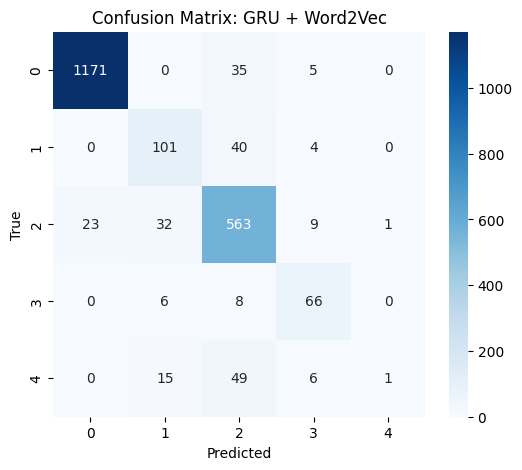


=== DL: CNN with Emoji2Vec embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 6s - 47ms/step - accuracy: 0.6149 - loss: 1.0589 - val_accuracy: 0.6604 - val_loss: 1.0114
Epoch 2/8


121/121 - 0s - 4ms/step - accuracy: 0.6702 - loss: 0.9142 - val_accuracy: 0.6698 - val_loss: 0.9106
Epoch 3/8


121/121 - 1s - 5ms/step - accuracy: 0.6935 - loss: 0.8376 - val_accuracy: 0.6944 - val_loss: 0.8354
Epoch 4/8


121/121 - 1s - 5ms/step - accuracy: 0.7081 - loss: 0.8005 - val_accuracy: 0.7084 - val_loss: 0.8164
Epoch 5/8
121/121 - 0s - 4ms/step - accuracy: 0.7086 - loss: 0.7845 - val_accuracy: 0.7061 - val_loss: 0.8198
Epoch 6/8


121/121 - 0s - 4ms/step - accuracy: 0.7109 - loss: 0.7724 - val_accuracy: 0.7201 - val_loss: 0.7967
Epoch 7/8
121/121 - 0s - 4ms/step - accuracy: 0.7129 - loss: 0.7642 - val_accuracy: 0.7190 - val_loss: 0.8162
Epoch 8/8
121/121 - 1s - 5ms/step - accuracy: 0.7198 - loss: 0.7495 - val_accuracy: 0.6674 - val_loss: 0.8021
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

CNN + Emoji2Vec | Acc: 0.7171 | Prec(macro): 0.3476 | Rec(macro): 0.3126 | F1(macro): 0.2975
              precision    recall  f1-score   support

           0       0.74      0.95      0.83      1211
           1       0.33      0.01      0.03       145
           2       0.67      0.60      0.63       628
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        71

    accuracy                           0.72      2135
   macro avg       0.35      0.31      0.30      2135
weighted avg       0.64      0.72      0.66      2135



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


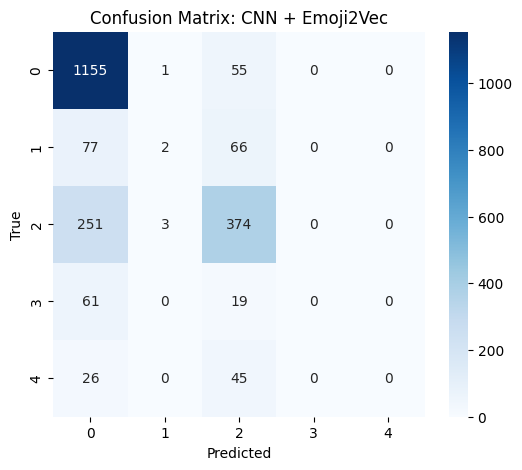


=== DL: RNN with Emoji2Vec embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 7s - 58ms/step - accuracy: 0.5362 - loss: 1.1425 - val_accuracy: 0.5738 - val_loss: 1.0801
Epoch 2/8
121/121 - 1s - 9ms/step - accuracy: 0.5571 - loss: 1.1210 - val_accuracy: 0.5691 - val_loss: 1.1261
Epoch 3/8
121/121 - 1s - 7ms/step - accuracy: 0.5672 - loss: 1.1150 - val_accuracy: 0.5691 - val_loss: 1.1256
Epoch 4/8
121/121 - 1s - 7ms/step - accuracy: 0.5667 - loss: 1.1096 - val_accuracy: 0.5691 - val_loss: 1.1390
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

RNN + Emoji2Vec | Acc: 0.5766 | Prec(macro): 0.2763 | Rec(macro): 0.2065 | F1(macro): 0.1586
              precision    recall  f1-score   support

           0       0.57      1.00      0.73      1211
           1       0.00      0.00      0.00       145
           2       0.81      0.03      0.06       628
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        71

    accuracy                           0.58      2135
   macro avg       0.28      0.21      0.16      2135
w

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


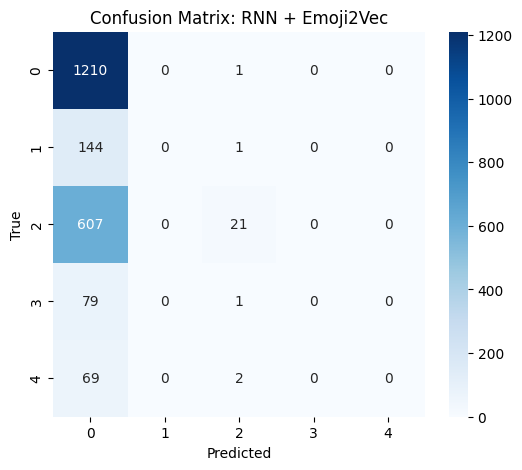


=== DL: LSTM with Emoji2Vec embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 3s - 25ms/step - accuracy: 0.5589 - loss: 1.1513 - val_accuracy: 0.5691 - val_loss: 1.1200
Epoch 2/8
121/121 - 2s - 18ms/step - accuracy: 0.5672 - loss: 1.1087 - val_accuracy: 0.5691 - val_loss: 1.1280
Epoch 3/8
121/121 - 1s - 8ms/step - accuracy: 0.5672 - loss: 1.1066 - val_accuracy: 0.5691 - val_loss: 1.1218
Epoch 4/8
121/121 - 1s - 11ms/step - accuracy: 0.5672 - loss: 1.1072 - val_accuracy: 0.5691 - val_loss: 1.1220
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

LSTM + Emoji2Vec | Acc: 0.5672 | Prec(macro): 0.1134 | Rec(macro): 0.2000 | F1(macro): 0.1448
              precision    recall  f1-score   support

           0       0.57      1.00      0.72      1211
           1       0.00      0.00      0.00       145
           2       0.00      0.00      0.00       628
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        71

    accuracy                           0.57      2135
   macro avg       0.11      0.20      0.14      2135

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


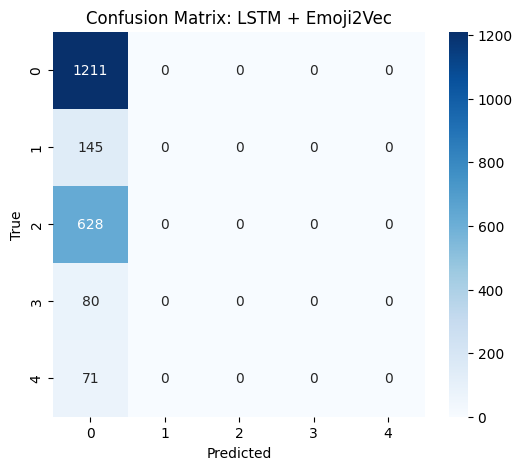


=== DL: BiLSTM with Emoji2Vec embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 5s - 40ms/step - accuracy: 0.5800 - loss: 1.0978 - val_accuracy: 0.6042 - val_loss: 1.0822
Epoch 2/8


121/121 - 2s - 17ms/step - accuracy: 0.6933 - loss: 0.8936 - val_accuracy: 0.7073 - val_loss: 0.8344
Epoch 3/8


121/121 - 1s - 12ms/step - accuracy: 0.7101 - loss: 0.7751 - val_accuracy: 0.6991 - val_loss: 0.7847
Epoch 4/8


121/121 - 1s - 11ms/step - accuracy: 0.7203 - loss: 0.7337 - val_accuracy: 0.7119 - val_loss: 0.7581
Epoch 5/8


121/121 - 1s - 12ms/step - accuracy: 0.7336 - loss: 0.7053 - val_accuracy: 0.7131 - val_loss: 0.7257
Epoch 6/8
121/121 - 3s - 22ms/step - accuracy: 0.7135 - loss: 0.7702 - val_accuracy: 0.6979 - val_loss: 0.7364
Epoch 7/8


121/121 - 2s - 20ms/step - accuracy: 0.7288 - loss: 0.7117 - val_accuracy: 0.7213 - val_loss: 0.7139
Epoch 8/8


121/121 - 2s - 21ms/step - accuracy: 0.7302 - loss: 0.6874 - val_accuracy: 0.7084 - val_loss: 0.7084
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

BiLSTM + Emoji2Vec | Acc: 0.7335 | Prec(macro): 0.5602 | Rec(macro): 0.4351 | F1(macro): 0.4382
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1211
           1       0.62      0.03      0.07       145
           2       0.58      0.75      0.66       628
           3       0.76      0.53      0.62        80
           4       0.00      0.00      0.00        71

    accuracy                           0.73      2135
   macro avg       0.56      0.44      0.44      2135
weighted avg       0.71      0.73      0.70      2135



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


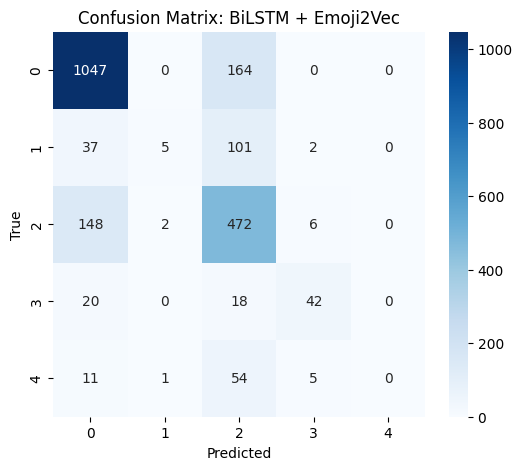


=== DL: GRU with Emoji2Vec embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 3s - 23ms/step - accuracy: 0.5411 - loss: 1.1641 - val_accuracy: 0.5691 - val_loss: 1.1209
Epoch 2/8
121/121 - 1s - 8ms/step - accuracy: 0.5672 - loss: 1.1062 - val_accuracy: 0.5691 - val_loss: 1.1291
Epoch 3/8
121/121 - 2s - 13ms/step - accuracy: 0.5672 - loss: 1.1089 - val_accuracy: 0.5691 - val_loss: 1.1265
Epoch 4/8


121/121 - 1s - 10ms/step - accuracy: 0.5672 - loss: 1.1028 - val_accuracy: 0.5691 - val_loss: 1.1206
Epoch 5/8


121/121 - 1s - 9ms/step - accuracy: 0.5672 - loss: 1.1018 - val_accuracy: 0.5691 - val_loss: 1.1202
Epoch 6/8
121/121 - 1s - 8ms/step - accuracy: 0.5672 - loss: 1.1005 - val_accuracy: 0.5691 - val_loss: 1.1249
Epoch 7/8
121/121 - 1s - 8ms/step - accuracy: 0.5672 - loss: 1.1024 - val_accuracy: 0.5691 - val_loss: 1.1214
Epoch 8/8
121/121 - 1s - 8ms/step - accuracy: 0.5672 - loss: 1.1024 - val_accuracy: 0.5691 - val_loss: 1.1243
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

GRU + Emoji2Vec | Acc: 0.5672 | Prec(macro): 0.1134 | Rec(macro): 0.2000 | F1(macro): 0.1448
              precision    recall  f1-score   support

           0       0.57      1.00      0.72      1211
           1       0.00      0.00      0.00       145
           2       0.00      0.00      0.00       628
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        71

    accuracy                           0.57      2135
   macro avg       0.11      0.20      0.14      2135
wei

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


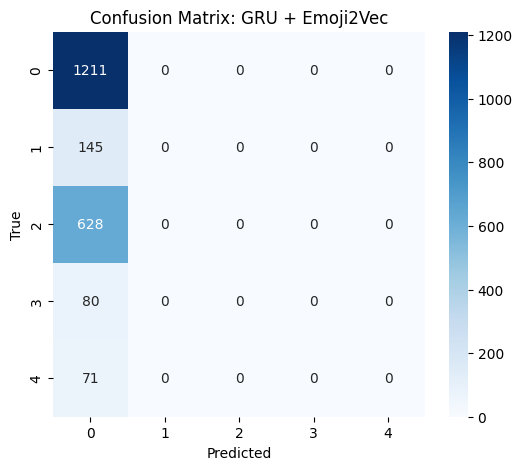


=== DL: CNN with FastText embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 7s - 57ms/step - accuracy: 0.6356 - loss: 0.9579 - val_accuracy: 0.6956 - val_loss: 0.8782
Epoch 2/8


121/121 - 1s - 5ms/step - accuracy: 0.6957 - loss: 0.8138 - val_accuracy: 0.6967 - val_loss: 0.8152
Epoch 3/8


121/121 - 1s - 5ms/step - accuracy: 0.7453 - loss: 0.7138 - val_accuracy: 0.7646 - val_loss: 0.7014
Epoch 4/8


121/121 - 1s - 5ms/step - accuracy: 0.7751 - loss: 0.6370 - val_accuracy: 0.7822 - val_loss: 0.6329
Epoch 5/8


121/121 - 1s - 4ms/step - accuracy: 0.8010 - loss: 0.5691 - val_accuracy: 0.7763 - val_loss: 0.6242
Epoch 6/8


121/121 - 1s - 5ms/step - accuracy: 0.8213 - loss: 0.5164 - val_accuracy: 0.8115 - val_loss: 0.5753
Epoch 7/8
121/121 - 0s - 4ms/step - accuracy: 0.8421 - loss: 0.4665 - val_accuracy: 0.8091 - val_loss: 0.5846
Epoch 8/8


121/121 - 1s - 4ms/step - accuracy: 0.8527 - loss: 0.4291 - val_accuracy: 0.8244 - val_loss: 0.5257
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

CNN + FastText | Acc: 0.8426 | Prec(macro): 0.8004 | Rec(macro): 0.5994 | F1(macro): 0.6615
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1211
           1       0.75      0.48      0.58       145
           2       0.81      0.87      0.83       628
           3       0.92      0.42      0.58        80
           4       0.66      0.30      0.41        71

    accuracy                           0.84      2135
   macro avg       0.80      0.60      0.66      2135
weighted avg       0.84      0.84      0.83      2135



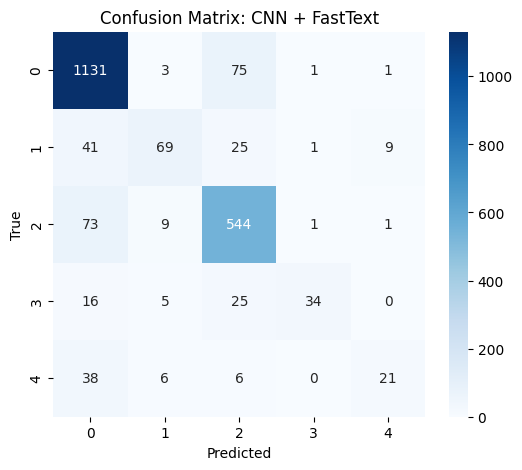


=== DL: RNN with FastText embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 8s - 62ms/step - accuracy: 0.5400 - loss: 1.1565 - val_accuracy: 0.5667 - val_loss: 1.1257
Epoch 2/8
121/121 - 1s - 10ms/step - accuracy: 0.5564 - loss: 1.1231 - val_accuracy: 0.5691 - val_loss: 1.1413
Epoch 3/8


121/121 - 1s - 9ms/step - accuracy: 0.5545 - loss: 1.1268 - val_accuracy: 0.5691 - val_loss: 1.1215
Epoch 4/8
121/121 - 1s - 10ms/step - accuracy: 0.5569 - loss: 1.1282 - val_accuracy: 0.5691 - val_loss: 1.1293
Epoch 5/8
121/121 - 1s - 9ms/step - accuracy: 0.5640 - loss: 1.1164 - val_accuracy: 0.5691 - val_loss: 1.1313
Epoch 6/8
121/121 - 1s - 10ms/step - accuracy: 0.5672 - loss: 1.1108 - val_accuracy: 0.5691 - val_loss: 1.1339
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

RNN + FastText | Acc: 0.5672 | Prec(macro): 0.1134 | Rec(macro): 0.2000 | F1(macro): 0.1448
              precision    recall  f1-score   support

           0       0.57      1.00      0.72      1211
           1       0.00      0.00      0.00       145
           2       0.00      0.00      0.00       628
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        71

    accuracy                           0.57      2135
   macro avg       0.11      0.20      0.14      2135
we

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


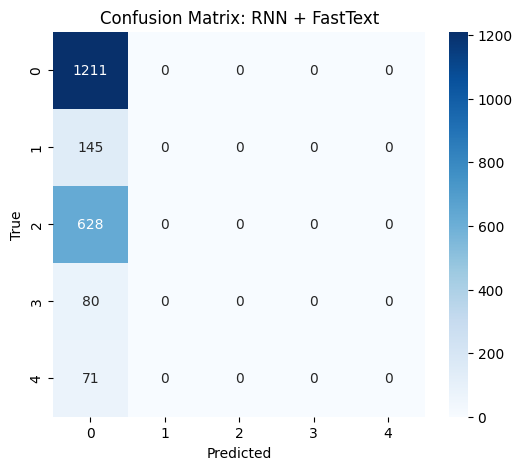


=== DL: LSTM with FastText embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 3s - 27ms/step - accuracy: 0.5670 - loss: 1.0836 - val_accuracy: 0.5843 - val_loss: 1.0104
Epoch 2/8
121/121 - 2s - 17ms/step - accuracy: 0.6298 - loss: 0.9226 - val_accuracy: 0.5597 - val_loss: 1.0726
Epoch 3/8


121/121 - 1s - 11ms/step - accuracy: 0.6747 - loss: 0.8649 - val_accuracy: 0.7166 - val_loss: 0.8231
Epoch 4/8


121/121 - 1s - 8ms/step - accuracy: 0.7237 - loss: 0.7774 - val_accuracy: 0.7248 - val_loss: 0.7690
Epoch 5/8
121/121 - 1s - 9ms/step - accuracy: 0.7332 - loss: 0.7574 - val_accuracy: 0.7272 - val_loss: 0.7765
Epoch 6/8


121/121 - 1s - 11ms/step - accuracy: 0.7616 - loss: 0.7428 - val_accuracy: 0.7518 - val_loss: 0.7391
Epoch 7/8


121/121 - 1s - 12ms/step - accuracy: 0.7816 - loss: 0.6711 - val_accuracy: 0.7400 - val_loss: 0.6841
Epoch 8/8
121/121 - 2s - 19ms/step - accuracy: 0.7543 - loss: 0.7318 - val_accuracy: 0.7576 - val_loss: 0.8180
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

LSTM + FastText | Acc: 0.7756 | Prec(macro): 0.3027 | Rec(macro): 0.3607 | F1(macro): 0.3261
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1211
           1       0.00      0.00      0.00       145
           2       0.61      0.91      0.73       628
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        71

    accuracy                           0.78      2135
   macro avg       0.30      0.36      0.33      2135
weighted avg       0.69      0.78      0.73      2135



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


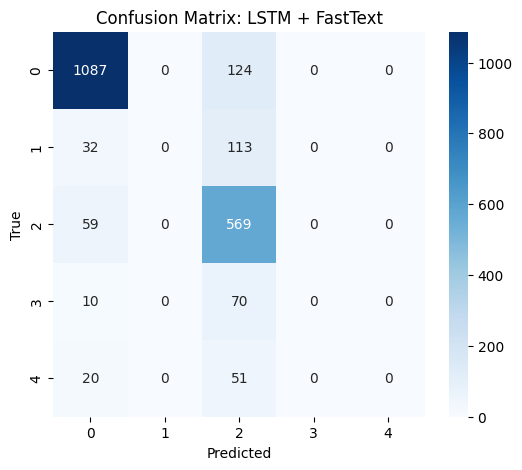


=== DL: BiLSTM with FastText embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 4s - 35ms/step - accuracy: 0.6382 - loss: 0.9463 - val_accuracy: 0.6710 - val_loss: 0.9378
Epoch 2/8


121/121 - 1s - 12ms/step - accuracy: 0.7065 - loss: 0.8096 - val_accuracy: 0.7260 - val_loss: 0.7564
Epoch 3/8


121/121 - 3s - 25ms/step - accuracy: 0.7328 - loss: 0.7398 - val_accuracy: 0.7482 - val_loss: 0.7106
Epoch 4/8


121/121 - 2s - 12ms/step - accuracy: 0.7601 - loss: 0.6720 - val_accuracy: 0.7646 - val_loss: 0.6478
Epoch 5/8


121/121 - 3s - 21ms/step - accuracy: 0.7808 - loss: 0.6215 - val_accuracy: 0.7799 - val_loss: 0.6216
Epoch 6/8


121/121 - 1s - 12ms/step - accuracy: 0.7930 - loss: 0.5811 - val_accuracy: 0.8009 - val_loss: 0.5649
Epoch 7/8


121/121 - 3s - 21ms/step - accuracy: 0.8115 - loss: 0.5257 - val_accuracy: 0.8056 - val_loss: 0.5556
Epoch 8/8


121/121 - 3s - 22ms/step - accuracy: 0.8309 - loss: 0.4891 - val_accuracy: 0.8197 - val_loss: 0.5266
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

BiLSTM + FastText | Acc: 0.8431 | Prec(macro): 0.7496 | Rec(macro): 0.6068 | F1(macro): 0.6535
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1211
           1       0.73      0.55      0.63       145
           2       0.85      0.81      0.83       628
           3       0.85      0.35      0.50        80
           4       0.45      0.37      0.40        71

    accuracy                           0.84      2135
   macro avg       0.75      0.61      0.65      2135
weighted avg       0.84      0.84      0.83      2135



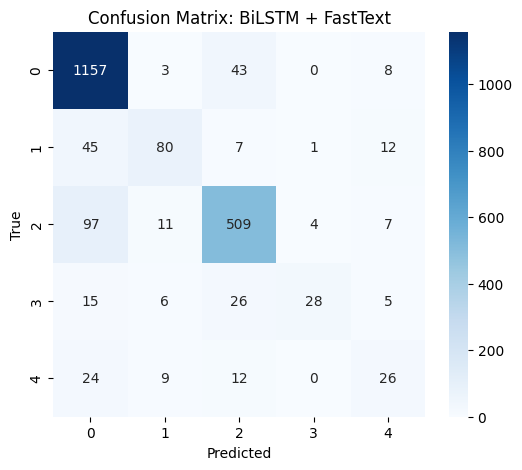


=== DL: GRU with FastText embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 3s - 24ms/step - accuracy: 0.5658 - loss: 1.1642 - val_accuracy: 0.5679 - val_loss: 1.1084
Epoch 2/8


121/121 - 2s - 18ms/step - accuracy: 0.5895 - loss: 0.9771 - val_accuracy: 0.6007 - val_loss: 0.9297
Epoch 3/8


121/121 - 1s - 8ms/step - accuracy: 0.6581 - loss: 0.8496 - val_accuracy: 0.6874 - val_loss: 0.7977
Epoch 4/8


121/121 - 1s - 10ms/step - accuracy: 0.7234 - loss: 0.7725 - val_accuracy: 0.7319 - val_loss: 0.7790
Epoch 5/8


121/121 - 1s - 11ms/step - accuracy: 0.7727 - loss: 0.6886 - val_accuracy: 0.7998 - val_loss: 0.6576
Epoch 6/8


121/121 - 2s - 13ms/step - accuracy: 0.8200 - loss: 0.6036 - val_accuracy: 0.7974 - val_loss: 0.6337
Epoch 7/8


121/121 - 2s - 19ms/step - accuracy: 0.8407 - loss: 0.5209 - val_accuracy: 0.8466 - val_loss: 0.4965
Epoch 8/8
121/121 - 1s - 8ms/step - accuracy: 0.8564 - loss: 0.4535 - val_accuracy: 0.8431 - val_loss: 0.4972
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

GRU + FastText | Acc: 0.8534 | Prec(macro): 0.6630 | Rec(macro): 0.5483 | F1(macro): 0.5818
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1211
           1       0.68      0.49      0.57       145
           2       0.85      0.90      0.87       628
           3       0.91      0.40      0.56        80
           4       0.00      0.00      0.00        71

    accuracy                           0.85      2135
   macro avg       0.66      0.55      0.58      2135
weighted avg       0.82      0.85      0.83      2135



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


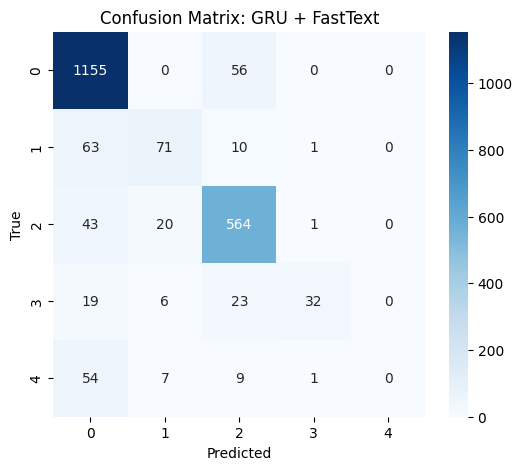


=== DL: CNN with BERT embeddings ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/8


121/121 - 8s - 66ms/step - accuracy: 0.7146 - loss: 0.7648 - val_accuracy: 0.8513 - val_loss: 0.4353
Epoch 2/8


121/121 - 4s - 36ms/step - accuracy: 0.9235 - loss: 0.2337 - val_accuracy: 0.9063 - val_loss: 0.2814
Epoch 3/8
121/121 - 1s - 5ms/step - accuracy: 0.9638 - loss: 0.1076 - val_accuracy: 0.8970 - val_loss: 0.3245
Epoch 4/8
121/121 - 1s - 11ms/step - accuracy: 0.9831 - loss: 0.0538 - val_accuracy: 0.9157 - val_loss: 0.3361
Epoch 5/8
121/121 - 1s - 5ms/step - accuracy: 0.9885 - loss: 0.0383 - val_accuracy: 0.9169 - val_loss: 0.3657
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

CNN + BERT | Acc: 0.9208 | Prec(macro): 0.8902 | Rec(macro): 0.8158 | F1(macro): 0.8468
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1211
           1       0.73      0.76      0.75       145
           2       0.90      0.92      0.91       628
           3       0.93      0.78      0.84        80
           4       0.94      0.66      0.78        71

    accuracy                           0.92      2135
   macro avg       0.89      0.82      0.85      2135
weight

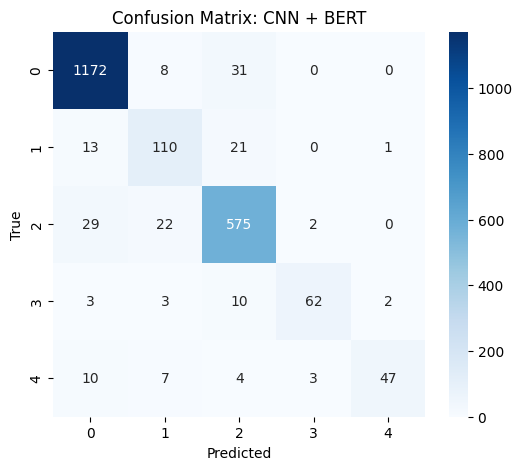


=== DL: RNN with BERT embeddings ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/8


121/121 - 8s - 65ms/step - accuracy: 0.5304 - loss: 1.1883 - val_accuracy: 0.5691 - val_loss: 1.1108
Epoch 2/8
121/121 - 1s - 11ms/step - accuracy: 0.5524 - loss: 1.1269 - val_accuracy: 0.5691 - val_loss: 1.1118
Epoch 3/8
121/121 - 3s - 21ms/step - accuracy: 0.5497 - loss: 1.1372 - val_accuracy: 0.5094 - val_loss: 1.1601
Epoch 4/8
121/121 - 1s - 11ms/step - accuracy: 0.5473 - loss: 1.1405 - val_accuracy: 0.5691 - val_loss: 1.1322
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

RNN + BERT | Acc: 0.5672 | Prec(macro): 0.1134 | Rec(macro): 0.2000 | F1(macro): 0.1448
              precision    recall  f1-score   support

           0       0.57      1.00      0.72      1211
           1       0.00      0.00      0.00       145
           2       0.00      0.00      0.00       628
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        71

    accuracy                           0.57      2135
   macro avg       0.11      0.20      0.14      2135
wei

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


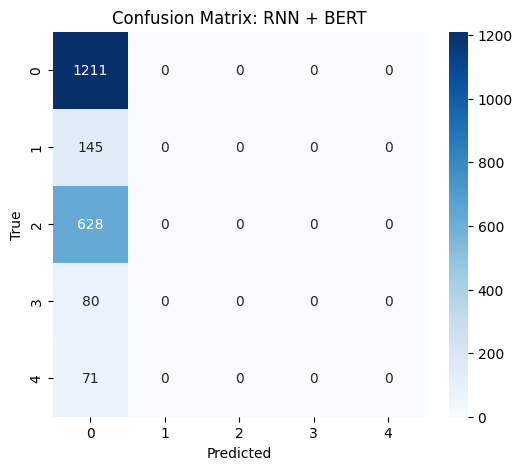


=== DL: LSTM with BERT embeddings ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/8


121/121 - 4s - 30ms/step - accuracy: 0.6525 - loss: 0.9030 - val_accuracy: 0.7588 - val_loss: 0.6744
Epoch 2/8


121/121 - 2s - 13ms/step - accuracy: 0.7884 - loss: 0.6268 - val_accuracy: 0.7881 - val_loss: 0.6160
Epoch 3/8
121/121 - 1s - 10ms/step - accuracy: 0.8074 - loss: 0.6078 - val_accuracy: 0.7670 - val_loss: 0.7521
Epoch 4/8
121/121 - 1s - 11ms/step - accuracy: 0.7185 - loss: 0.7626 - val_accuracy: 0.7014 - val_loss: 0.7711
Epoch 5/8
121/121 - 2s - 13ms/step - accuracy: 0.6746 - loss: 0.7770 - val_accuracy: 0.6089 - val_loss: 0.8441
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

LSTM + BERT | Acc: 0.7944 | Prec(macro): 0.3066 | Rec(macro): 0.3623 | F1(macro): 0.3306
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1211
           1       0.00      0.00      0.00       145
           2       0.62      0.85      0.72       628
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        71

    accuracy                           0.79      2135
   macro avg       0.31      0.36      0.33      2135
wei

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


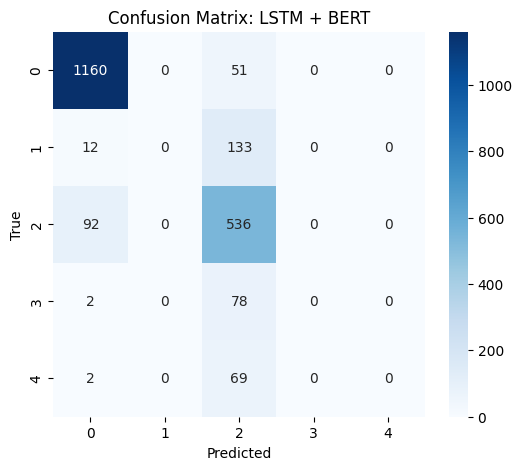


=== DL: BiLSTM with BERT embeddings ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/8


121/121 - 5s - 42ms/step - accuracy: 0.7526 - loss: 0.6468 - val_accuracy: 0.8934 - val_loss: 0.3401
Epoch 2/8


121/121 - 2s - 19ms/step - accuracy: 0.9242 - loss: 0.2135 - val_accuracy: 0.9052 - val_loss: 0.2671
Epoch 3/8


121/121 - 3s - 23ms/step - accuracy: 0.9655 - loss: 0.1131 - val_accuracy: 0.9309 - val_loss: 0.2267
Epoch 4/8


121/121 - 5s - 40ms/step - accuracy: 0.9876 - loss: 0.0443 - val_accuracy: 0.9461 - val_loss: 0.2017
Epoch 5/8
121/121 - 2s - 17ms/step - accuracy: 0.9762 - loss: 0.0731 - val_accuracy: 0.9344 - val_loss: 0.2626
Epoch 6/8
121/121 - 3s - 21ms/step - accuracy: 0.9971 - loss: 0.0131 - val_accuracy: 0.9450 - val_loss: 0.2367
Epoch 7/8
121/121 - 3s - 24ms/step - accuracy: 0.9990 - loss: 0.0052 - val_accuracy: 0.9461 - val_loss: 0.2305
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

BiLSTM + BERT | Acc: 0.9494 | Prec(macro): 0.9052 | Rec(macro): 0.8680 | F1(macro): 0.8856
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1211
           1       0.81      0.80      0.80       145
           2       0.97      0.94      0.95       628
           3       0.92      0.84      0.88        80
           4       0.87      0.77      0.82        71

    accuracy                           0.95      2135
   macro avg       0.91      0.87      0.89      2135
w

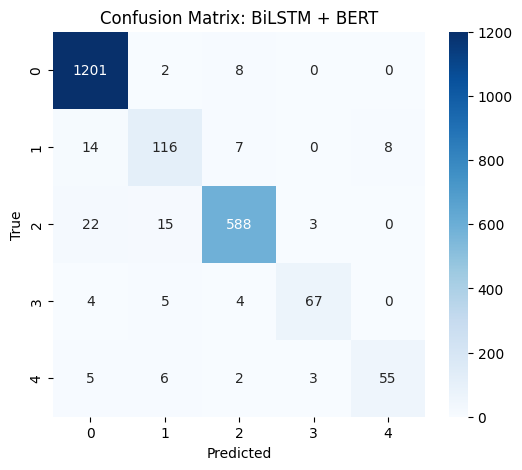


=== DL: GRU with BERT embeddings ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/8


121/121 - 3s - 27ms/step - accuracy: 0.5674 - loss: 1.1624 - val_accuracy: 0.5691 - val_loss: 1.1240
Epoch 2/8


121/121 - 2s - 18ms/step - accuracy: 0.5925 - loss: 1.0044 - val_accuracy: 0.6569 - val_loss: 0.8227
Epoch 3/8


121/121 - 3s - 23ms/step - accuracy: 0.7027 - loss: 0.6964 - val_accuracy: 0.8747 - val_loss: 0.4264
Epoch 4/8


121/121 - 2s - 18ms/step - accuracy: 0.8895 - loss: 0.3711 - val_accuracy: 0.9087 - val_loss: 0.3162
Epoch 5/8


121/121 - 1s - 12ms/step - accuracy: 0.9334 - loss: 0.2457 - val_accuracy: 0.9251 - val_loss: 0.2562
Epoch 6/8


121/121 - 1s - 11ms/step - accuracy: 0.9517 - loss: 0.1841 - val_accuracy: 0.9356 - val_loss: 0.2097
Epoch 7/8
121/121 - 1s - 10ms/step - accuracy: 0.9629 - loss: 0.1347 - val_accuracy: 0.9379 - val_loss: 0.2180
Epoch 8/8


121/121 - 1s - 11ms/step - accuracy: 0.9732 - loss: 0.0910 - val_accuracy: 0.9426 - val_loss: 0.2002
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

GRU + BERT | Acc: 0.9489 | Prec(macro): 0.8900 | Rec(macro): 0.9030 | F1(macro): 0.8962
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1211
           1       0.85      0.83      0.84       145
           2       0.93      0.93      0.93       628
           3       0.86      0.89      0.87        80
           4       0.83      0.89      0.86        71

    accuracy                           0.95      2135
   macro avg       0.89      0.90      0.90      2135
weighted avg       0.95      0.95      0.95      2135



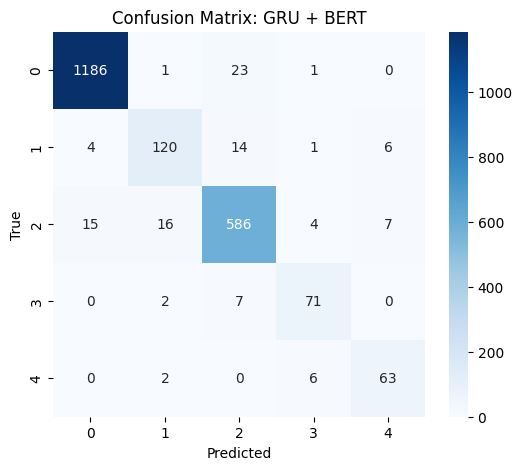


=== DL: CNN with RAND embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 8s - 67ms/step - accuracy: 0.6751 - loss: 0.8581 - val_accuracy: 0.8115 - val_loss: 0.5295
Epoch 2/8


121/121 - 1s - 6ms/step - accuracy: 0.8826 - loss: 0.3096 - val_accuracy: 0.9016 - val_loss: 0.2704
Epoch 3/8


121/121 - 1s - 5ms/step - accuracy: 0.9597 - loss: 0.1114 - val_accuracy: 0.9403 - val_loss: 0.2004
Epoch 4/8


121/121 - 1s - 5ms/step - accuracy: 0.9915 - loss: 0.0352 - val_accuracy: 0.9520 - val_loss: 0.1911
Epoch 5/8
121/121 - 1s - 4ms/step - accuracy: 0.9977 - loss: 0.0109 - val_accuracy: 0.9614 - val_loss: 0.2132
Epoch 6/8
121/121 - 0s - 4ms/step - accuracy: 0.9992 - loss: 0.0046 - val_accuracy: 0.9590 - val_loss: 0.2202
Epoch 7/8
121/121 - 0s - 4ms/step - accuracy: 0.9996 - loss: 0.0024 - val_accuracy: 0.9543 - val_loss: 0.2339
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

CNN + RAND | Acc: 0.9607 | Prec(macro): 0.9083 | Rec(macro): 0.8821 | F1(macro): 0.8887
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1211
           1       0.77      0.87      0.82       145
           2       0.96      0.98      0.97       628
           3       0.98      0.68      0.80        80
           4       0.83      0.90      0.86        71

    accuracy                           0.96      2135
   macro avg       0.91      0.88      0.89      2135
weighted

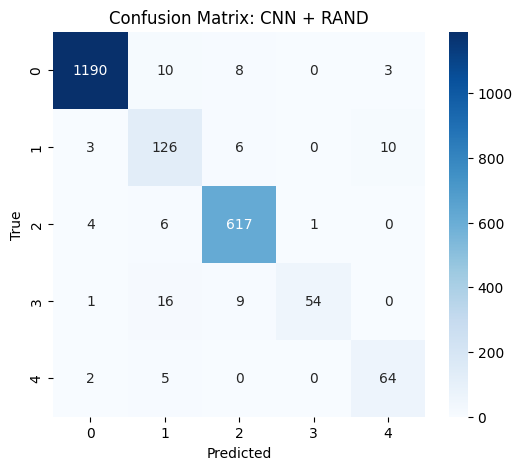


=== DL: RNN with RAND embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 8s - 65ms/step - accuracy: 0.5437 - loss: 1.1530 - val_accuracy: 0.5691 - val_loss: 1.1252
Epoch 2/8


121/121 - 6s - 50ms/step - accuracy: 0.5666 - loss: 1.1130 - val_accuracy: 0.5691 - val_loss: 1.1176
Epoch 3/8
121/121 - 1s - 9ms/step - accuracy: 0.5672 - loss: 1.1115 - val_accuracy: 0.5691 - val_loss: 1.1246
Epoch 4/8
121/121 - 1s - 10ms/step - accuracy: 0.5671 - loss: 1.1122 - val_accuracy: 0.5691 - val_loss: 1.1237
Epoch 5/8
121/121 - 1s - 9ms/step - accuracy: 0.5667 - loss: 1.1120 - val_accuracy: 0.5691 - val_loss: 1.1240
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

RNN + RAND | Acc: 0.5672 | Prec(macro): 0.1134 | Rec(macro): 0.2000 | F1(macro): 0.1448
              precision    recall  f1-score   support

           0       0.57      1.00      0.72      1211
           1       0.00      0.00      0.00       145
           2       0.00      0.00      0.00       628
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        71

    accuracy                           0.57      2135
   macro avg       0.11      0.20      0.14      2135
weight

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


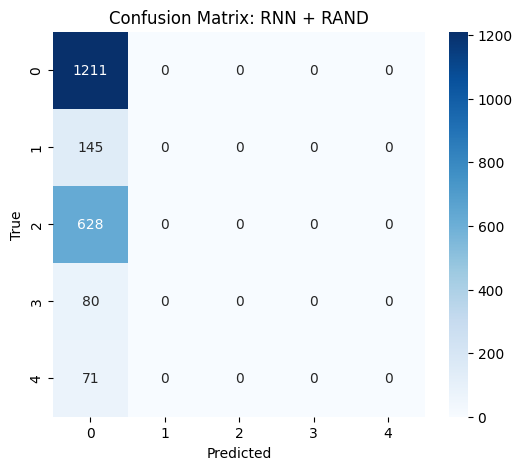


=== DL: LSTM with RAND embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 3s - 28ms/step - accuracy: 0.5602 - loss: 1.1347 - val_accuracy: 0.5691 - val_loss: 1.1240
Epoch 2/8
121/121 - 1s - 12ms/step - accuracy: 0.5672 - loss: 1.1146 - val_accuracy: 0.5691 - val_loss: 1.1272
Epoch 3/8


121/121 - 2s - 20ms/step - accuracy: 0.5672 - loss: 1.1053 - val_accuracy: 0.5691 - val_loss: 1.1233
Epoch 4/8
121/121 - 1s - 9ms/step - accuracy: 0.5672 - loss: 1.1055 - val_accuracy: 0.5691 - val_loss: 1.1350
Epoch 5/8


121/121 - 1s - 10ms/step - accuracy: 0.5672 - loss: 1.1056 - val_accuracy: 0.5691 - val_loss: 1.1229
Epoch 6/8


121/121 - 1s - 11ms/step - accuracy: 0.5672 - loss: 1.1049 - val_accuracy: 0.5691 - val_loss: 1.1210
Epoch 7/8
121/121 - 1s - 10ms/step - accuracy: 0.5672 - loss: 1.1033 - val_accuracy: 0.5691 - val_loss: 1.1229
Epoch 8/8
121/121 - 1s - 9ms/step - accuracy: 0.5670 - loss: 1.1021 - val_accuracy: 0.5691 - val_loss: 1.1244
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

LSTM + RAND | Acc: 0.5672 | Prec(macro): 0.1134 | Rec(macro): 0.2000 | F1(macro): 0.1448
              precision    recall  f1-score   support

           0       0.57      1.00      0.72      1211
           1       0.00      0.00      0.00       145
           2       0.00      0.00      0.00       628
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        71

    accuracy                           0.57      2135
   macro avg       0.11      0.20      0.14      2135
weighted avg       0.32      0.57      0.41      2135



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


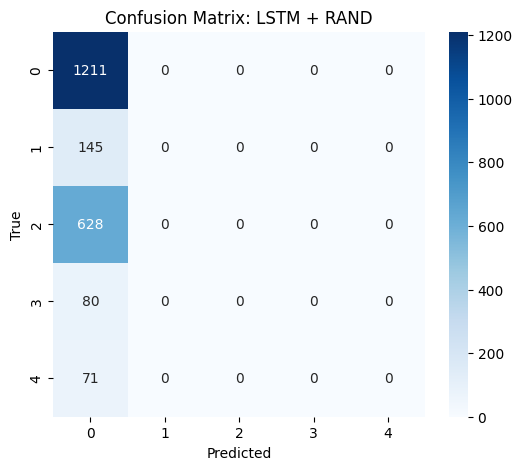


=== DL: BiLSTM with RAND embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 5s - 43ms/step - accuracy: 0.6926 - loss: 0.8587 - val_accuracy: 0.8220 - val_loss: 0.5127
Epoch 2/8


121/121 - 2s - 17ms/step - accuracy: 0.8822 - loss: 0.3229 - val_accuracy: 0.9087 - val_loss: 0.2701
Epoch 3/8


121/121 - 3s - 21ms/step - accuracy: 0.9430 - loss: 0.1474 - val_accuracy: 0.9473 - val_loss: 0.1936
Epoch 4/8
121/121 - 2s - 21ms/step - accuracy: 0.9771 - loss: 0.0737 - val_accuracy: 0.9415 - val_loss: 0.2813
Epoch 5/8


121/121 - 2s - 17ms/step - accuracy: 0.9913 - loss: 0.0347 - val_accuracy: 0.9590 - val_loss: 0.1877
Epoch 6/8


121/121 - 2s - 18ms/step - accuracy: 0.9962 - loss: 0.0136 - val_accuracy: 0.9578 - val_loss: 0.1856
Epoch 7/8


121/121 - 2s - 21ms/step - accuracy: 0.9965 - loss: 0.0140 - val_accuracy: 0.9602 - val_loss: 0.1687
Epoch 8/8
121/121 - 2s - 13ms/step - accuracy: 0.9983 - loss: 0.0079 - val_accuracy: 0.9614 - val_loss: 0.1791
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

BiLSTM + RAND | Acc: 0.9649 | Prec(macro): 0.9187 | Rec(macro): 0.9161 | F1(macro): 0.9162
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1211
           1       0.87      0.88      0.87       145
           2       0.99      0.95      0.97       628
           3       0.97      0.88      0.92        80
           4       0.79      0.89      0.83        71

    accuracy                           0.96      2135
   macro avg       0.92      0.92      0.92      2135
weighted avg       0.97      0.96      0.96      2135



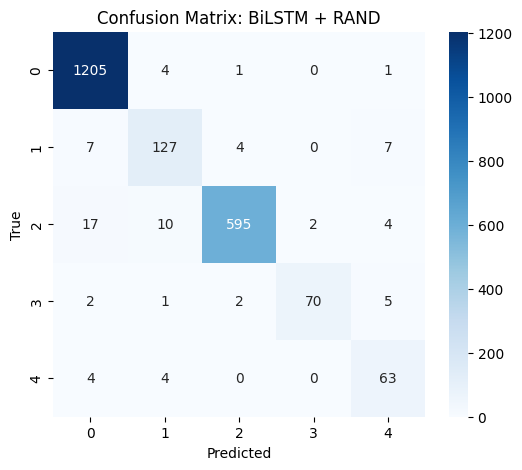


=== DL: GRU with RAND embeddings ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 - 4s - 31ms/step - accuracy: 0.5599 - loss: 1.1515 - val_accuracy: 0.5691 - val_loss: 1.1279
Epoch 2/8
121/121 - 1s - 9ms/step - accuracy: 0.5657 - loss: 1.1110 - val_accuracy: 0.5691 - val_loss: 1.1305
Epoch 3/8
121/121 - 1s - 9ms/step - accuracy: 0.5672 - loss: 1.1056 - val_accuracy: 0.5691 - val_loss: 1.1305
Epoch 4/8
121/121 - 1s - 11ms/step - accuracy: 0.5672 - loss: 1.1027 - val_accuracy: 0.5691 - val_loss: 1.1296
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

GRU + RAND | Acc: 0.5672 | Prec(macro): 0.1134 | Rec(macro): 0.2000 | F1(macro): 0.1448
              precision    recall  f1-score   support

           0       0.57      1.00      0.72      1211
           1       0.00      0.00      0.00       145
           2       0.00      0.00      0.00       628
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        71

    accuracy                           0.57      2135
   macro avg       0.11      0.20      0.14      2135
weight

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


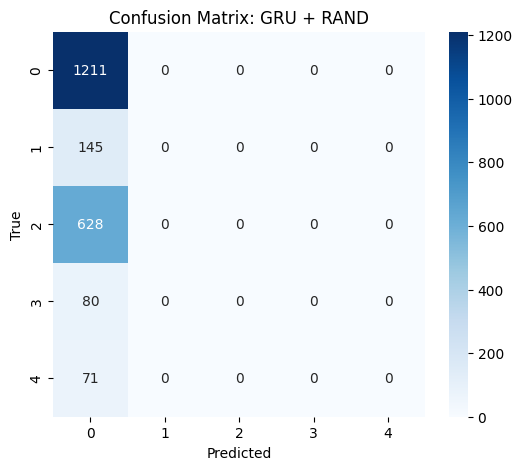

In [ ]:
def make_dl_model(model_type, embedding_matrix=None, trainable_emb=False, input_len=MAX_LEN, emb_dim=100, num_classes=num_classes):
    model = Sequential()
    if embedding_matrix is not None:
        model.add(Embedding(input_dim=vocab_size, output_dim=embedding_matrix.shape[1],
                            input_length=input_len, weights=[embedding_matrix], trainable=trainable_emb))
    else:
        model.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=input_len))
    if model_type == "CNN":
        model.add(Conv1D(128, 5, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
    elif model_type == "RNN":
        model.add(SimpleRNN(128))
    elif model_type == "LSTM":
        model.add(LSTM(128))
    elif model_type == "BiLSTM":
        model.add(Bidirectional(LSTM(128)))
    elif model_type == "GRU":
        model.add(GRU(128))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


dl_models = ["CNN", "RNN", "LSTM", "BiLSTM", "GRU"]
emb_configs = {
    "TFIDF": tfidf_emb_matrix,
    "Word2Vec": w2v_emb_matrix,
    "Emoji2Vec": emoji_vec_emb_matrix,
    "FastText": ft_emb_matrix,
    "BERT": bert_emb_matrix,
    "RAND": None
}

dl_results = []
os.makedirs("conf_matrices", exist_ok=True) # Create the directory

for emb_name, emb_matrix in emb_configs.items():
    for mtype in dl_models:
        print("\n=== DL:", mtype, "with", emb_name, "embeddings ===")
        # Adjust emb_dim if using precomputed embeddings with different dimensions
        current_emb_dim = emb_matrix.shape[1] if emb_matrix is not None else 100
        model = make_dl_model(mtype, embedding_matrix=emb_matrix, trainable_emb=False, emb_dim=current_emb_dim)

        es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        ckpt_path = f"models/dl_{mtype}_{emb_name}.h5"
        mc = ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True)
        history = model.fit(X_train_pad, y_train_cat, validation_split=0.1, epochs=8, batch_size=64, callbacks=[es, mc], verbose=2)
        preds_proba = model.predict(X_test_pad)
        preds = preds_proba.argmax(axis=1)
        metrics = eval_and_report(f"{mtype} + {emb_name}", y_test, preds, output_prefix=f"conf_matrices/{mtype}_{emb_name}")
        metrics.update({"model": mtype, "feature": emb_name})
        dl_results.append(metrics)
        # Save Keras model
        os.makedirs("models", exist_ok=True) # Ensure models directory exists
        model.save(ckpt_path)
        gc.collect()

Training LogisticRegression on BERT features


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LogReg + BERT | Acc: 0.7850 | Prec(macro): 0.6025 | Rec(macro): 0.7536 | F1(macro): 0.6481
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1211
           1       0.44      0.72      0.55       145
           2       0.85      0.74      0.79       628
           3       0.40      0.81      0.53        80
           4       0.39      0.68      0.49        71

    accuracy                           0.79      2135
   macro avg       0.60      0.75      0.65      2135
weighted avg       0.84      0.79      0.80      2135



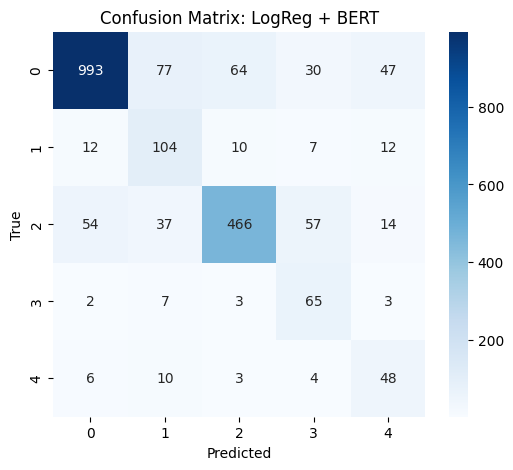

In [ ]:
# Simple Logistic Regression on BERT embeddings
print("Training LogisticRegression on BERT features")
clf_bert = LogisticRegression(max_iter=1000, class_weight='balanced')
clf_bert.fit(X_train_bert, y_train)
y_pred_bert = clf_bert.predict(X_test_bert)
bert_metrics = eval_and_report("LogReg + BERT", y_test, y_pred_bert, output_prefix="conf_matrices/LogReg_BERT")
bert_metrics.update({"model":"LogisticRegression","feature":"BERT"})


In [ ]:

#for validation loss and accuracy results visualization

epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, 'b', color='red', label='Train')
plt.plot(epochs, val_loss_values, 'b', color='blue',label='Test')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, accuracy_values, 'b', color='red', label='Train')
plt.plot(epochs, val_accuracy_values, 'b', color='blue', label='Test')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'loss_values' is not defined

In [ ]:
# ML results already saved in results_df earlier
# Ensure the ml_results_summary.csv file exists and is not empty before reading
try:
    ml_df_loaded = pd.read_csv("ml_results_summary.csv")
except pd.errors.EmptyDataError:
    ml_df_loaded = pd.DataFrame() # Create an empty DataFrame if the file is empty

dl_df = pd.DataFrame(dl_results)

# Combine all results, ensuring ML results from the current run are included
ml_results_current_run = pd.DataFrame(results)
all_results = pd.concat([ml_results_current_run, dl_df, pd.DataFrame([bert_metrics])], ignore_index=True, sort=False)
all_results = all_results[['model','feature','accuracy','precision_macro','recall_macro','f1_macro']]
all_results.to_csv("all_models_results_summary.csv", index=False)

# Separate ML and DL results
ml_results_df = all_results[all_results['model'].isin(ml_models.keys())].sort_values('f1_macro', ascending=False)
dl_results_df = all_results[all_results['model'].isin(dl_models + ['LogisticRegression'])].sort_values('f1_macro', ascending=False) # Include LogReg for BERT in DL table

print("--- ML Model Results (Sorted by F1 Macro) ---")
display(ml_results_df.head(300))

print("\n--- DL Model Results (Sorted by F1 Macro) ---")
display(dl_results_df.head(300))

--- ML Model Results (Sorted by F1 Macro) ---


,model,feature,accuracy,precision_macro,recall_macro,f1_macro
1,SVM,TFIDF,0.962998,0.955120,0.921794,0.937270
2,RandomForest,TFIDF,0.960656,0.937945,0.910520,0.923272
4,GradientBoosting,TFIDF,0.948009,0.904990,0.920880,0.911272
0,LogisticRegression,TFIDF,0.941920,0.901260,0.910397,0.905018
3,DecisionTree,TFIDF,0.960656,0.880939,0.924007,0.900564
7,SVM,Word2Vec,0.877283,0.731263,0.761522,0.741842
8,RandomForest,Word2Vec,0.849649,0.856059,0.667160,0.734827
40,LogisticRegression,BERT,0.785012,0.602510,0.753564,0.648068
6,LogisticRegression,Word2Vec,0.807026,0.613937,0.717969,0.646362
9,DecisionTree,Word2Vec,0.736300,0.593842,0.590512,0.590380



--- DL Model Results (Sorted by F1 Macro) ---


,model,feature,accuracy,precision_macro,recall_macro,f1_macro
38,BiLSTM,RAND,0.964871,0.918733,0.916137,0.916221
0,LogisticRegression,TFIDF,0.941920,0.901260,0.910397,0.905018
34,GRU,BERT,0.948946,0.889965,0.902977,0.896179
35,CNN,RAND,0.960656,0.908344,0.882103,0.888675
33,BiLSTM,BERT,0.949415,0.905156,0.868039,0.885557
30,CNN,BERT,0.920843,0.890184,0.815799,0.846766
15,CNN,Word2Vec,0.877752,0.778152,0.713301,0.735613
18,BiLSTM,Word2Vec,0.870726,0.724134,0.642943,0.667273
25,CNN,FastText,0.842623,0.800353,0.599364,0.661487
19,GRU,Word2Vec,0.890867,0.735997,0.679820,0.660871


In [ ]:
# ML results already saved in results_df earlier
# Ensure the ml_results_summary.csv file exists and is not empty before reading
try:
    ml_df = pd.read_csv("ml_results_summary.csv")
except pd.errors.EmptyDataError:
    ml_df = pd.DataFrame() # Create an empty DataFrame if the file is empty

dl_df = pd.DataFrame(dl_results)
# Include the results from the ML model loop
all_results = pd.concat([pd.DataFrame(results), dl_df, pd.DataFrame([bert_metrics])], ignore_index=True, sort=False)
all_results = all_results[['model','feature','accuracy','precision_macro','recall_macro','f1_macro']].sort_values('f1_macro', ascending=False)
all_results.to_csv("all_models_results_summary.csv", index=False)
all_results.head(100)

In [ ]:
best = all_results.iloc[0]
print("Best model:", best.to_dict())
best_model_name = best['model']
best_feature = best['feature']
print("Best combination:", best_model_name, best_feature)

Best model: {'model': 'SVM', 'feature': 'TFIDF', 'accuracy': 0.9629976580796253, 'precision_macro': 0.9551200971679581, 'recall_macro': 0.9217937509947882, 'f1_macro': 0.9372699493243777}
Best combination: SVM TFIDF
